In [1]:
import pandas as pd
import numpy as np

# Apna file path
csv_path = r"D:\HARISH\QSAR article\MAO-B FULL DATA.csv"

# Load data
df = pd.read_csv(csv_path)
print("Dataset shape:", df.shape)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\HARISH\\QSAR article\\MAO-B FULL DATA.csv'

In [4]:
# Use exact column names as in your CSV
df = df.dropna(subset=['Smiles', 'Standard Value'])
df = df[df['Standard Value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
df = df.drop_duplicates(subset='Molecule ChEMBL ID')
df['IC50_nM'] = df['Standard Value'].astype(float)
df['pIC50'] = 9 - np.log10(df['IC50_nM'])

In [5]:
# After cleaning and converting IC50 to pIC50, save the curated dataframe
df.to_csv('QSAR_curated_data.csv', index=False)


In [6]:
print(df.columns)


Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties',
       'Action Type', 'Standard Text Value', 'V

In [10]:
from rdkit.Chem import Descriptors

# Get descriptor functions and names as list of tuples
all_descriptors = Descriptors._descList

def compute_descriptors(mol):
    values = []
    for name, func in all_descriptors:
        try:
            value = func(mol) if mol is not None else None
        except Exception:
            value = None
        values.append(value)
    return values

desc_values = df['ROMol'].apply(compute_descriptors)
desc_names = [name for name, func in all_descriptors]
desc_df = pd.DataFrame(desc_values.tolist(), columns=desc_names)


In [11]:
# Concatenate descriptors with original curated data if desired
full_df = pd.concat([df.reset_index(drop=True), desc_df], axis=1)  # optional

# Save either full_df or desc_df depending on what you want
desc_df.to_csv('QSAR_descriptors.csv', index=False)
# Or, if you want the concatenated file with all metadata:
full_df.to_csv('QSAR_descriptors_full.csv', index=False)


In [12]:
import pandas as pd
import numpy as np

# Load full data
df_full = pd.read_csv('QSAR_descriptors_full.csv', low_memory=False)

# Columns known to be non-numeric (IDs, SMILES, target)
non_numeric_cols = ['Molecule ChEMBL ID', 'Smiles', 'pIC50']

# Drop non-numeric columns before numeric processing (keep pIC50 separate if needed)
X = df_full.drop(columns=non_numeric_cols)

# Force convert all remaining columns to numeric, coercing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Optional: Check how many NaNs per column (to decide imputation or removal)
nan_counts = X.isna().sum()

# Impute missing values (NaN) with median
X_imputed = X.fillna(X.median())

# Now calculate correlation matrix on fully numeric, imputed data
corr_matrix = X_imputed.corr().abs()

# Proceed with filtering high correlations as before
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.90)]

# Drop highly correlated descriptors
X_filtered = X_imputed.drop(columns=high_corr)


In [13]:
# Keep only numeric columns for correlation heatmap
desc_numeric = desc_df.select_dtypes(include=['number'])

# Then plot correlation heatmap on numeric subset
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 12))
sns.heatmap(desc_numeric.corr(), cmap='Spectral', linewidths=0.3, annot=True, fmt=".2f", annot_kws={"size":6})
plt.title('Correlation Heatmap of Processed Descriptors')
plt.tight_layout()
plt.savefig('QSAR_descriptors_full_heatmap.png', dpi=300)
plt.show()


In [14]:
import pandas as pd

# Step 1: Load your CSV file into 'data'
data = pd.read_csv('QSAR_descriptors_full.csv', low_memory=False)

# Step 2: Now you can manipulate 'data'
exclude_cols = ['pIC50', 'Molecule ChEMBL ID', 'Smiles', 'Molecule Name',
                'Standard Type', 'Standard Relation', 'Standard Units', 'Standard Text Value']

X = data.drop(columns=exclude_cols, errors='ignore')


In [15]:
exclude_cols = ['pIC50', 'Molecule ChEMBL ID', 'Smiles', 'Molecule Name', 'Standard Type', 'Standard Relation', 'Standard Units', 'Standard Text Value']
X = data.drop(columns=exclude_cols, errors='ignore')


In [16]:
X = X.apply(pd.to_numeric, errors='coerce')


In [17]:
X = X.fillna(X.median())


In [18]:
import numpy as np

# After imputation, remove constant columns (std == 0)
non_constant_cols = X.loc[:, X.std(axis=0) > 0].columns
X_filtered = X[non_constant_cols]

# Then split and scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = data['pIC50']
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Train Random Forest on scaled training data
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

# Extract feature importances
importances = rf.feature_importances_
feature_names = X_train.columns  # Original feature names before scaling

# Create DataFrame for importances
feat_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_importance = feat_importance.sort_values(by='importance', ascending=False)

# Select top 20 most important descriptors
top_features = feat_importance['feature'].head(20).tolist()
print("Top 20 important features:\n", top_features)


Top 20 important features:
 ['IC50_nM', 'Standard Value', 'pChEMBL Value', 'PEOE_VSA4', 'BCUT2D_CHGHI', 'VSA_EState7', 'Ligand Efficiency LLE', 'Value', 'PEOE_VSA2', 'BCUT2D_LOGPHI', 'MinEStateIndex', 'EState_VSA2', 'VSA_EState2', 'VSA_EState1', 'MinAbsPartialCharge', 'Document Year', 'SlogP_VSA2', 'fr_halogen', 'fr_C_O', 'BCUT2D_MRLOW']


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred = rf.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='orange', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Observed pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Observed vs Predicted pIC50 (Test Set)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Observed_vs_Predicted_pIC50_Train.png', dpi=300)
plt.show()


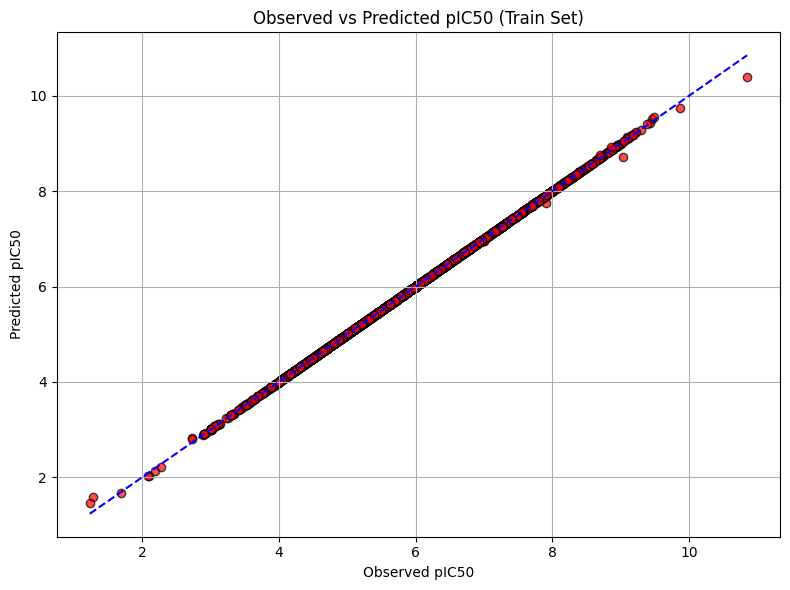

In [21]:
# Predict on training data
y_train_pred = rf.predict(X_train_scaled)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(y_train, y_train_pred, color='red', edgecolor='k', alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b--')
plt.xlabel('Observed pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Observed vs Predicted pIC50 (Train Set)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Observed_vs_Predicted_pIC50_Train.png', dpi=300)
plt.show()


In [22]:
import numpy as np

# Detect infinite values
print("Any infinite values in X?", np.isinf(X).values.any())

# Detect very large values (e.g., above 1e10)
print("Any values > 1e10 in X?", (X.abs() > 1e10).any().any())


Any infinite values in X? False
Any values > 1e10 in X? True


In [23]:
# Replace infinite with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Impute NaNs with median
X = X.fillna(X.median())


In [24]:
X = X.clip(lower=-1e10, upper=1e10)


In [25]:
print("Any NaNs in X after imputation?", X.isna().sum().sum())
print("Any infinite after cleaning?", np.isinf(X).values.any())


Any NaNs in X after imputation? 124592
Any infinite after cleaning? False


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor

# Load full data with low_memory=False to avoid dtype warnings
data = pd.read_csv('QSAR_descriptors_full.csv', low_memory=False)

# List non-numeric columns to exclude from features
exclude_cols = ['pIC50', 'Molecule ChEMBL ID', 'Smiles', 'Molecule Name', 'Standard Type', 
                'Standard Relation', 'Standard Units', 'Standard Text Value']

# Drop non-numeric columns
X = data.drop(columns=exclude_cols, errors='ignore')

# Force convert all columns to numeric, coercing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Replace infinite values with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Impute NaNs with median
X = X.fillna(X.median())

# Optionally clip extreme values if needed (adjust bounds if desired)
X = X.clip(lower=-1e10, upper=1e10)

# Remove zero variance columns (std == 0)
X = X.loc[:, X.std() > 0]

# Target vector
y = data['pIC50']

# Initialize model
rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)

# Define scoring metrics
scoring = {
    'R2': 'r2',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error'
}

# Perform 5-fold cross-validation
cv_results = cross_validate(rf, X, y, cv=5, scoring=scoring, n_jobs=-1, return_train_score=False)

# Convert negative scores to positive and compute RMSE
mse_scores = -cv_results['test_MSE']
rmse_scores = np.sqrt(mse_scores)
mae_scores = -cv_results['test_MAE']
r2_scores = cv_results['test_R2']
q2_scores = r2_scores  # Q² is equivalent to R² in cross-validation

# Print metrics summary
print(f"5-Fold CV R² scores: {r2_scores}")
print(f"Mean R²: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}\n")

print(f"5-Fold CV RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}\n")

print(f"5-Fold CV MAE scores: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores):.3f} ± {np.std(mae_scores):.3f}\n")

print(f"5-Fold CV MSE scores: {mse_scores}")
print(f"Mean MSE: {np.mean(mse_scores):.3f} ± {np.std(mse_scores):.3f}\n")

print(f"5-Fold CV Q² scores (equivalent to R²): {q2_scores}")
print(f"Mean Q²: {np.mean(q2_scores):.3f} ± {np.std(q2_scores):.3f}")


5-Fold CV R² scores: [0.99983083 0.99961789 0.99991598 0.99959031 0.99836564]
Mean R²: 0.999 ± 0.001

5-Fold CV RMSE scores: [0.0177018  0.02668841 0.01172605 0.02581613 0.05526598]
Mean RMSE: 0.027 ± 0.015

5-Fold CV MAE scores: [0.0028251  0.00328345 0.00214963 0.00232743 0.0045183 ]
Mean MAE: 0.003 ± 0.001

5-Fold CV MSE scores: [0.00031335 0.00071227 0.0001375  0.00066647 0.00305433]
Mean MSE: 0.001 ± 0.001

5-Fold CV Q² scores (equivalent to R²): [0.99983083 0.99961789 0.99991598 0.99959031 0.99836564]
Mean Q²: 0.999 ± 0.001


In [27]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assume rf is your RandomForestRegressor instance already initialized

# Train model on training data
rf.fit(X_train_scaled, y_train)

# Predict on training set
y_train_pred = rf.predict(X_train_scaled)

# Predict on test set
y_test_pred = rf.predict(X_test_scaled)

# Calculate metrics for training set
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

# Calculate metrics for test set
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

# Print results
print("Training set performance:")
print(f"R²: {r2_train:.3f}")
print(f"RMSE: {rmse_train:.3f}")
print(f"MAE: {mae_train:.3f}\n")

print("Test set performance:")
print(f"R²: {r2_test:.3f}")
print(f"RMSE: {rmse_test:.3f}")
print(f"MAE: {mae_test:.3f}")


Training set performance:
R²: 1.000
RMSE: 0.012
MAE: 0.001

Test set performance:
R²: 1.000
RMSE: 0.012
MAE: 0.002


In [28]:
# Correlate features to target
corr_to_target = X.corrwith(y).abs().sort_values(ascending=False)
print(corr_to_target.head(10))


pChEMBL Value            0.847585
Ligand Efficiency LE     0.572569
Ligand Efficiency BEI    0.567453
Ligand Efficiency LLE    0.530425
SlogP_VSA2               0.220013
FractionCSP3             0.207899
BCUT2D_LOGPLOW           0.207035
BCUT2D_CHGHI             0.203260
SMR_VSA6                 0.202706
BCUT2D_CHGLO             0.196582
dtype: float64


In [29]:
# List columns to exclude from model features (target-related leakage features)
exclude_cols += ['pChEMBL Value', 'IC50_nM', 'Standard Value']  # add all known target leakages here

# Drop these columns from the feature set before splitting and modeling
X = data.drop(columns=exclude_cols, errors='ignore')

# Proceed with numeric conversion, cleaning, splitting, scaling as before


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Step 1: Load your full dataset
data = pd.read_csv('QSAR_descriptors_full.csv', low_memory=False)

# Step 2: Specify columns known to cause leakage or non-numeric metadata
leakage_and_metadata_cols = [
    'pIC50', 'Molecule ChEMBL ID', 'Smiles', 'Molecule Name', 'Standard Type',
    'Standard Relation', 'Standard Units', 'Standard Text Value',
    'pChEMBL Value', 'IC50_nM', 'Standard Value'
]

# Step 3: Drop these leakage columns from features
X = data.drop(columns=leakage_and_metadata_cols, errors='ignore')

# Step 4: Target variable
y = data['pIC50']

# Step 5: Convert all remaining columns to numeric, coercing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Step 6: Replace infinite values with NaN, then impute with median
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Step 7: Remove zero variance columns
X = X.loc[:, X.std() > 0]

# Step 8: Split dataset into train and test (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Scale features (fit scaler only on train data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 10: Initialize and train Random Forest model
rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
rf.fit(X_train_scaled, y_train)

# Step 11: Predict on training and test sets
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

# Step 12: Calculate and print performance metrics
def print_metrics(true, pred, label):
    r2 = r2_score(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f"{label} performance:")
    print(f"R²: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}\n")

print_metrics(y_train, y_train_pred, 'Training set')
print_metrics(y_test, y_test_pred, 'Test set')


Training set performance:
R²: 0.994
RMSE: 0.101
MAE: 0.040

Test set performance:
R²: 0.962
RMSE: 0.265
MAE: 0.102



In [31]:
from sklearn.model_selection import cross_val_score

# Assuming X_train_scaled, y_train, rf already defined

# 5-fold CV on training data to get Q² (CV R²)
q2_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)

print(f"5-Fold CV Q² scores (training set): {q2_scores}")
print(f"Mean Q²: {q2_scores.mean():.3f} ± {q2_scores.std():.3f}")

# After training on full training set, evaluate on train and test as before
rf.fit(X_train_scaled, y_train)
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

# Function to print metrics including Q² (for train and test, Q² = R² here)
def print_metrics(true, pred, label, q2=None):
    r2 = r2_score(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f"{label} performance:")
    print(f"R²: {r2:.3f}")
    if q2 is not None:
        print(f"Q² (CV R²): {q2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}\n")

print_metrics(y_train, y_train_pred, 'Training set', q2_scores.mean())
print_metrics(y_test, y_test_pred, 'Test set')


5-Fold CV Q² scores (training set): [0.95756075 0.96012951 0.95773859 0.9396317  0.94438422]
Mean Q²: 0.952 ± 0.008
Training set performance:
R²: 0.994
Q² (CV R²): 0.952
RMSE: 0.101
MAE: 0.040

Test set performance:
R²: 0.962
RMSE: 0.265
MAE: 0.102



In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rf is your trained RandomForestRegressor
# And X_train is your training DataFrame (before scaling) with proper column names

importances = rf.feature_importances_
feature_names = X_train.columns

# Create DataFrame with feature importances
feat_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_importance = feat_importance.sort_values(by='importance', ascending=False)

# Select top 20 features
top_features = feat_importance['feature'].head(20).tolist()
print("Top 20 features:\n", top_features)


Top 20 features:
 ['Ligand Efficiency LE', 'Value', 'Ligand Efficiency LLE', 'AlogP', 'Ligand Efficiency BEI', 'Chi0', 'MolLogP', 'Ligand Efficiency SEI', 'LabuteASA', 'Chi1', 'Document Year', 'qed', 'SlogP_VSA6', 'BertzCT', 'HeavyAtomMolWt', 'SMR_VSA7', 'SlogP_VSA1', 'PEOE_VSA4', 'Kappa1', 'BCUT2D_MWLOW']


In [33]:
top_features_filtered = [f for f in top_features if f in X_train.columns]


In [34]:
desc_top20 = X_train[top_features_filtered]


In [35]:
# Filter top features that are in the current feature set
top_features_filtered = [f for f in top_features if f in X_train.columns]

# Subset your training data to these features only
desc_top20 = X_train[top_features_filtered]

# Then proceed with your correlation matrix and heatmap plot
corr_matrix = desc_top20.corr()
# (plotting code continues...)


In [36]:
chemical_descriptor_cols = [
    'Ligand Efficiency LE', 'Value', 'Ligand Efficiency LLE', 'AlogP', 'Ligand Efficiency BEI', 'Chi0',
    'MolLogP', 'Ligand Efficiency SEI', 'LabuteASA', 'Chi1', 'qed', 'SlogP_VSA6', 'BertzCT',
    'HeavyAtomMolWt', 'SMR_VSA7', 'SlogP_VSA1', 'PEOE_VSA4', 'Kappa1', 'BCUT2D_MWLOW'
    # Add any others, but ***DO NOT*** include metadata columns!
]


In [37]:
# Assuming feat_importance is your DataFrame from earlier
filtered_importance = feat_importance[feat_importance['feature'].isin(chemical_descriptor_cols)]

# Then select the top 20 from only chemical descriptors
top20_chem_desc = filtered_importance.sort_values(by='importance', ascending=False)['feature'].head(20).tolist()


In [38]:
desc_top20 = X_train[top20_chem_desc]  # Use this filtered feature list

plt.figure(figsize=(12, 10))
sns.heatmap(
    desc_top20.corr(),
    annot=True, cmap='Spectral', linewidths=0.3,
    fmt=".2f", annot_kws={"size":9}, square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Heatmap of Top 20 Chemical Descriptors')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('Top20_chemical_descriptors_heatmap.png', dpi=300)
plt.show()


In [39]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [40]:
conda install -c conda-forge shap numba


Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [42]:
import shap

# Initialize SHAP TreeExplainer with your trained model
explainer = shap.TreeExplainer(rf)

# Compute SHAP values on the test set (use scaled features for the model)
shap_values = explainer.shap_values(X_test_scaled)

# Optional: Map feature names for SHAP visualization, as X_test_scaled is numpy array
feature_names = X_test.columns.tolist()  # X_test should have same column order as used in scaling


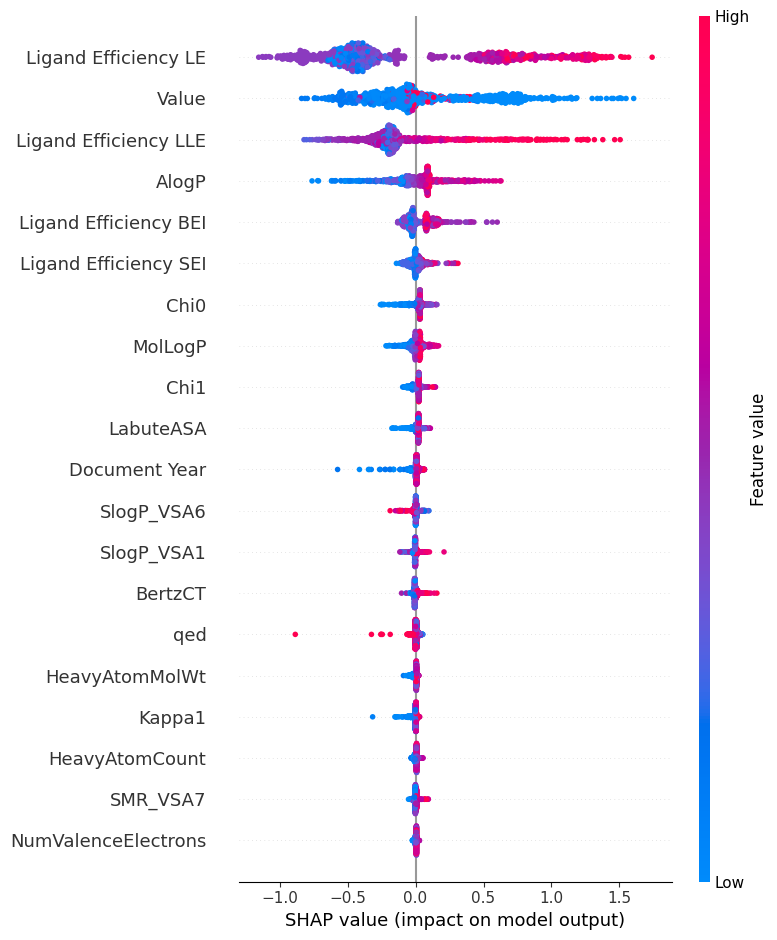

In [43]:
# SHAP summary plot with feature names
shap.summary_plot(shap_values, features=X_test_scaled, feature_names=feature_names)


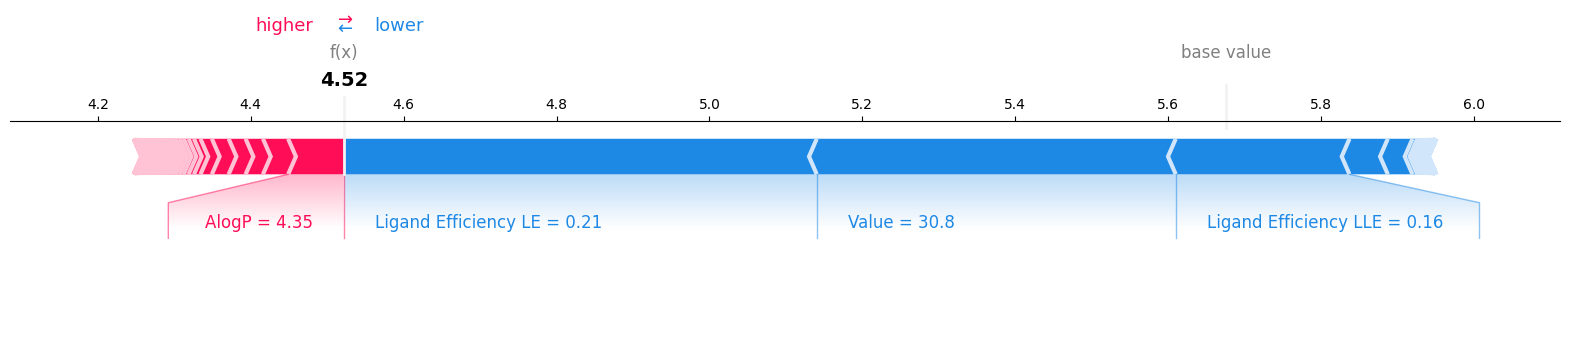

In [44]:
# Explain the first molecule in test set
shap.initjs()
shap.force_plot(
    explainer.expected_value, 
    shap_values[0,:], 
    X_test.iloc[0,:], 
    matplotlib=True,
    feature_names=feature_names
)


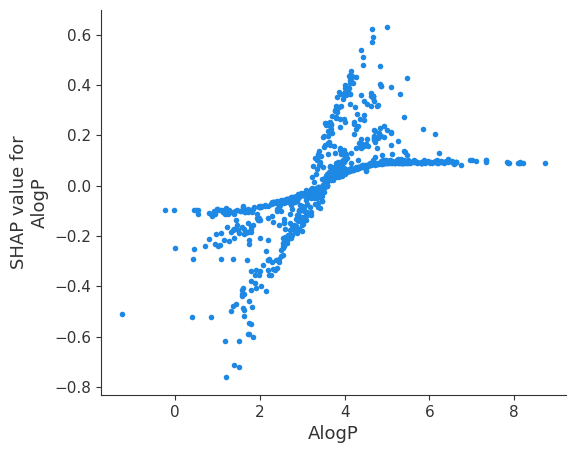

In [45]:
import shap

# Plot SHAP dependence for feature 'AlogP'
shap.dependence_plot('AlogP', shap_values, X_test, interaction_index=None)


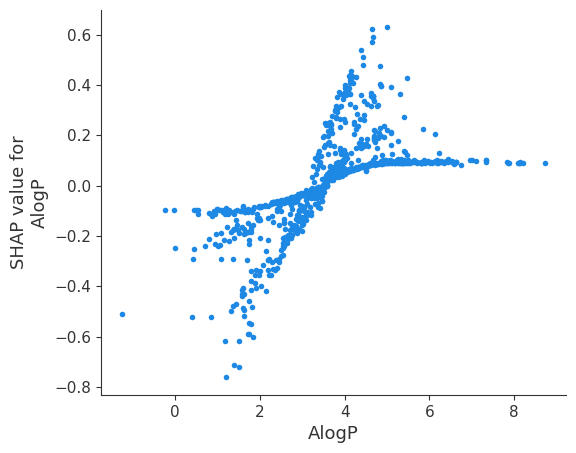

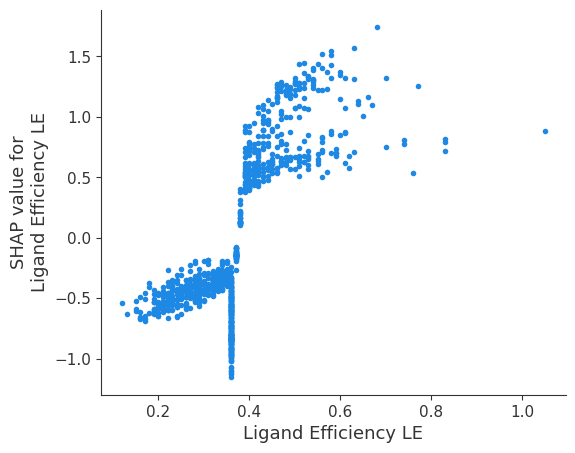

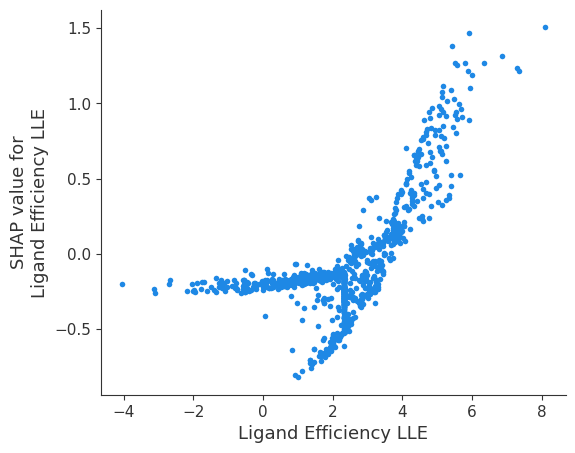

In [46]:
import shap

# Example: Dependence plot for top features like 'AlogP', 'Ligand Efficiency LE'
top_shap_features = ['AlogP', 'Ligand Efficiency LE', 'Ligand Efficiency LLE']  # adjust with your important features

for feature in top_shap_features:
    shap.dependence_plot(feature, shap_values, X_test, interaction_index=None)


In [47]:
def calculate_vip(pls, X):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_
    p, h = w.shape
    vip = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = sum(s)
    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        vip[i] = np.sqrt(p * (s.T @ weight).item() / total_s)  # <- Use .item() here to fix warning
    return vip


In [48]:
def calculate_vip(pls, X):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_
    p, h = w.shape
    vip = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = sum(s)
    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        vip[i] = np.sqrt(p * (s.T @ weight).item() / total_s)  # <- Use .item() here to fix warning
    return vip


In [56]:
def calculate_vip(pls, X):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_
    p, h = w.shape
    vip = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = sum(s)
    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        value = (s.T @ weight)
        if hasattr(value, 'shape') and np.ndim(value) > 0:
            value = value.flatten()[0]
        vip[i] = np.sqrt(p * value / total_s)
    return vip


In [57]:
from sklearn.cross_decomposition import PLSRegression
import numpy as np

def calculate_vip(pls, X):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_
    p, h = w.shape
    vip = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = sum(s)
    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        vip[i] = np.sqrt(p * (s.T @ weight).item() / total_s)  # Use .item() to avoid warning
    return vip

# Example usage (assuming X_train and y_train are defined and preprocessed):
pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train)
vip_scores = calculate_vip(pls, X_train)


C:\Users\Asus\AppData\Local\Temp\ipykernel_16152\1503036171.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vip[i] = np.sqrt(p * (s.T @ weight).item() / total_s)  # Use .item() to avoid warning


In [58]:
import pandas as pd
# Assuming you have vip_scores as a NumPy array and X_train as your DataFrame of descriptors
vip_df = pd.DataFrame({'feature': X_train.columns, 'VIP': vip_scores})


C:\Users\Asus\AppData\Local\Temp\ipykernel_16152\2205996254.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VIP', y='feature', data=vip_df_sorted, palette='viridis')


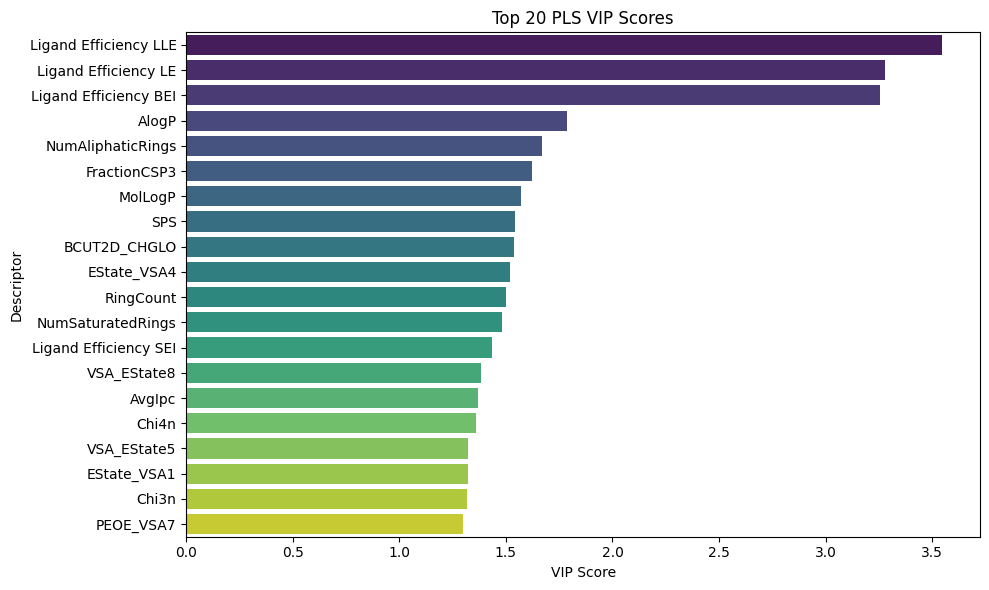

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort VIP scores descending
vip_df_sorted = vip_df.sort_values(by='VIP', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='VIP', y='feature', data=vip_df_sorted, palette='viridis')
plt.title('Top 20 PLS VIP Scores')
plt.xlabel('VIP Score')
plt.ylabel('Descriptor')
plt.tight_layout()
plt.show()


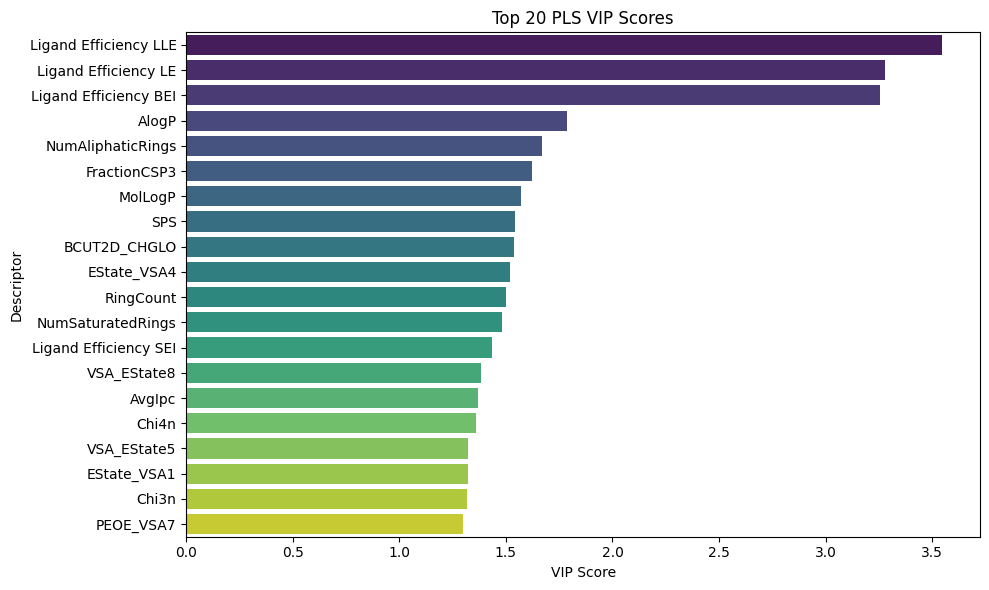

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort VIP scores descending and select top 20
vip_df_sorted = vip_df.sort_values(by='VIP', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='VIP',
    y='feature',
    hue='feature',          # Assign hue to feature for palette use
    data=vip_df_sorted,
    palette='viridis',
    legend=False            # Hide legend since feature names are on y-axis
)
plt.title('Top 20 PLS VIP Scores')
plt.xlabel('VIP Score')
plt.ylabel('Descriptor')
plt.tight_layout()
plt.show()


In [64]:
import pandas as pd
import numpy as np

# Calculate mean absolute SHAP value per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Create DataFrame with feature names and mean_abs_shap
shap_importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
})

# Sort descending
shap_importance_df = shap_importance_df.sort_values(by='mean_abs_shap', ascending=False)


In [62]:
import numpy as np
import pandas as pd

# Assuming shap_values is your SHAP values array for the dataset
# and X_train (or whatever your feature matrix) contains feature names

mean_abs_shap = np.abs(shap_values).mean(axis=0)  # mean absolute per feature

shap_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'mean_abs_shap': mean_abs_shap
})

# You can sort for convenience:
shap_importance_df = shap_importance_df.sort_values(by='mean_abs_shap', ascending=False)


In [63]:
combined_df = pd.merge(shap_importance_df, vip_df, on='feature', how='inner')
combined_df = combined_df.sort_values(by='mean_abs_shap', ascending=False)


In [64]:
combined_df = pd.merge(shap_importance_df, vip_df, on='feature', how='inner')

# Sort by SHAP or VIP scores
combined_df = combined_df.sort_values(by='mean_abs_shap', ascending=False)

print(combined_df.head(20))


                  feature  mean_abs_shap       VIP
0    Ligand Efficiency LE       0.608350  3.280796
1                   Value       0.347771  0.459181
2   Ligand Efficiency LLE       0.289058  3.547440
3                   AlogP       0.130378  1.787433
4   Ligand Efficiency BEI       0.077853  3.254626
5   Ligand Efficiency SEI       0.038634  1.432862
6                    Chi0       0.037987  1.160359
7                 MolLogP       0.031977  1.569219
8                    Chi1       0.024626  1.171537
9               LabuteASA       0.020789  1.170836
10          Document Year       0.019221  0.854662
11             SlogP_VSA6       0.010206  1.000728
12             SlogP_VSA1       0.009851  1.163343
13                BertzCT       0.009800  1.179077
14                    qed       0.009595  0.817121
15         HeavyAtomMolWt       0.008996  1.178006
16                 Kappa1       0.008566  1.143089
17         HeavyAtomCount       0.008348  1.167216
18               SMR_VSA7      

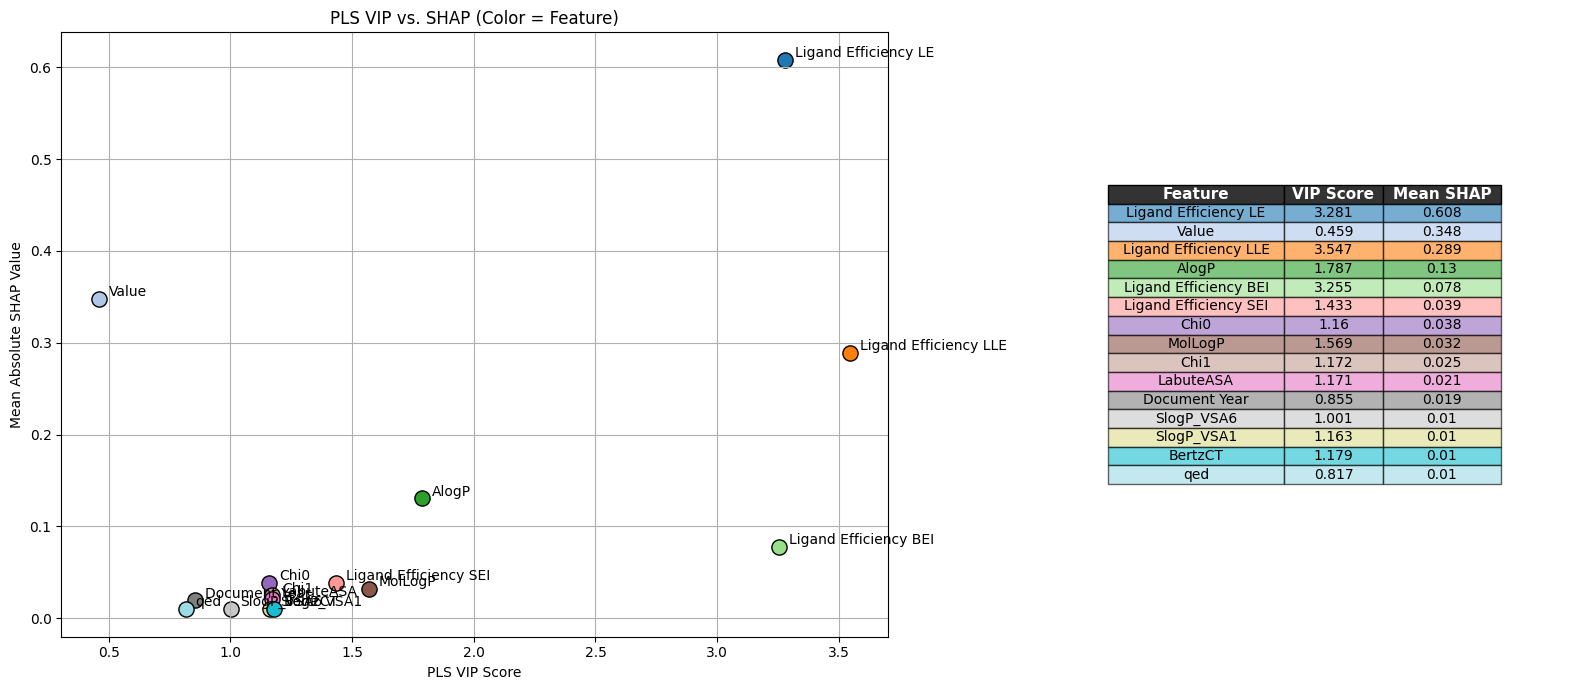

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Top N features
N = 15
top_combined = combined_df.sort_values('mean_abs_shap', ascending=False).head(N).copy()
colors = plt.cm.tab20(np.linspace(0, 1, N))

fig, axes = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios':[3,2]})

# Scatter plot
for i, (vip, shap, feature) in enumerate(zip(top_combined['VIP'], 
                                             top_combined['mean_abs_shap'], 
                                             top_combined['feature'])):
    axes[0].scatter(
        vip, shap,
        color=colors[i],
        s=120,
        edgecolor='k'
    )
    axes[0].annotate(feature, (vip, shap), fontsize=10, xytext=(7,2), textcoords='offset points')
axes[0].set_xlabel('PLS VIP Score')
axes[0].set_ylabel('Mean Absolute SHAP Value')
axes[0].set_title('PLS VIP vs. SHAP (Color = Feature)')
axes[0].grid(True)

# Table dataframe
table_df = top_combined[['feature','VIP','mean_abs_shap']].copy()
table_df.columns = ['Feature', 'VIP Score', 'Mean SHAP']
table_df['VIP Score'] = table_df['VIP Score'].round(3)
table_df['Mean SHAP'] = table_df['Mean SHAP'].round(3)

axes[1].axis('off')
mpl_table = axes[1].table(cellText=table_df.values, colLabels=table_df.columns,
                         cellLoc='center', loc='center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(10)
mpl_table.auto_set_column_width(col=list(range(len(table_df.columns))))

# Assign row color matching to scatter point
for i in range(N):
    for j in range(len(table_df.columns)):
        mpl_table[(i+1, j)].set_facecolor(colors[i])
        mpl_table[(i+1, j)].set_alpha(0.6)  # Transparency for readability

# Header bolder
for j in range(len(table_df.columns)):
    mpl_table[(0, j)].set_fontsize(11)
    mpl_table[(0, j)].set_facecolor('#333333')
    mpl_table[(0, j)].set_text_props(color='w', weight='bold')

plt.tight_layout()
plt.show()


In [66]:
# Assuming you have:
# - rf: your trained Random Forest model
# - X_test_scaled: scaled test feature matrix

y_pred_test = rf.predict(X_test_scaled)


In [69]:
def compute_metrics(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res/ss_tot
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))
    return r2, rmse, mae


In [70]:
try:
    print(compute_metrics)
except NameError:
    print("compute_metrics is not defined")


<function compute_metrics at 0x000002389BD4A700>


In [71]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

n_iter = 100
r2_scores, rmse_scores, mae_scores = [], [], []

for _ in range(n_iter):
    y_shuffled = np.random.permutation(y_train)
    rf_shuffled = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=None)
    rf_shuffled.fit(X_train_scaled, y_shuffled)
    y_pred_shuffle = rf_shuffled.predict(X_test_scaled)
    r2, rmse, mae = compute_metrics(y_test, y_pred_shuffle)
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

df_random = pd.DataFrame({'R2': r2_scores, 'RMSE': rmse_scores, 'MAE': mae_scores})
df_random.to_csv('Y_randomization_results.csv', index=False)
print(df_random.describe())


               R2        RMSE         MAE
count  100.000000  100.000000  100.000000
mean    -0.087019    1.407983    1.155083
std      0.032348    0.020933    0.018808
min     -0.168271    1.346782    1.103635
25%     -0.107151    1.394239    1.144310
50%     -0.084412    1.406447    1.154887
75%     -0.065667    1.421117    1.167203
max      0.005644    1.459816    1.198210


In [72]:
df_random.to_csv('Y_randomization_results.csv', index=False)


Real model R²: 0.962
Mean randomized R²: -0.087


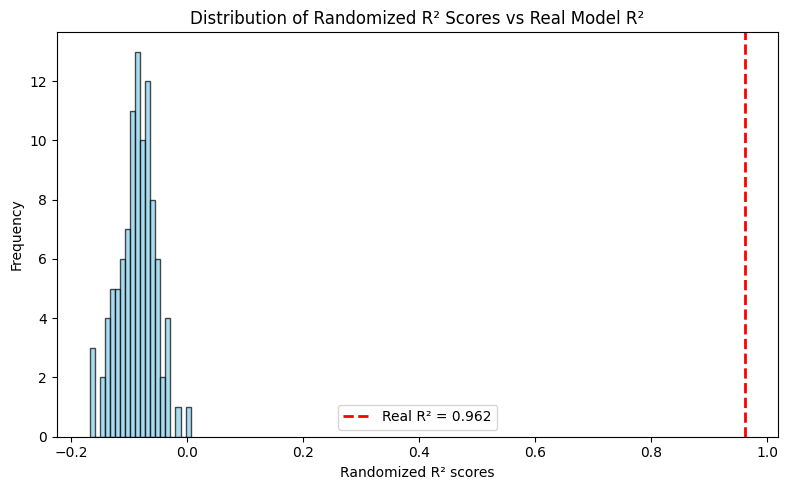

Permutation p-value: 0.0000


In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose:
# - r2_scores is your list/array of randomized R² from Y-randomization (length 100)
# - real_r2 is the R² of your actual model on test set (e.g., 0.962 from previous results)

real_r2 = 0.962
r2_scores = np.array(r2_scores)  # Convert to array if not already

# 1. Direct comparison (printed)
print(f"Real model R²: {real_r2:.3f}")
print(f"Mean randomized R²: {r2_scores.mean():.3f}")

# 2. Plot histogram with red line for real R²
plt.figure(figsize=(8, 5))
plt.hist(r2_scores, bins=20, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(real_r2, color='red', linestyle='dashed', linewidth=2, label=f'Real R² = {real_r2:.3f}')
plt.xlabel('Randomized R² scores')
plt.ylabel('Frequency')
plt.title('Distribution of Randomized R² Scores vs Real Model R²')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Permutation p-value = fraction of randomized R² >= real R²
p_value = np.sum(r2_scores >= real_r2) / len(r2_scores)
print(f"Permutation p-value: {p_value:.4f}")


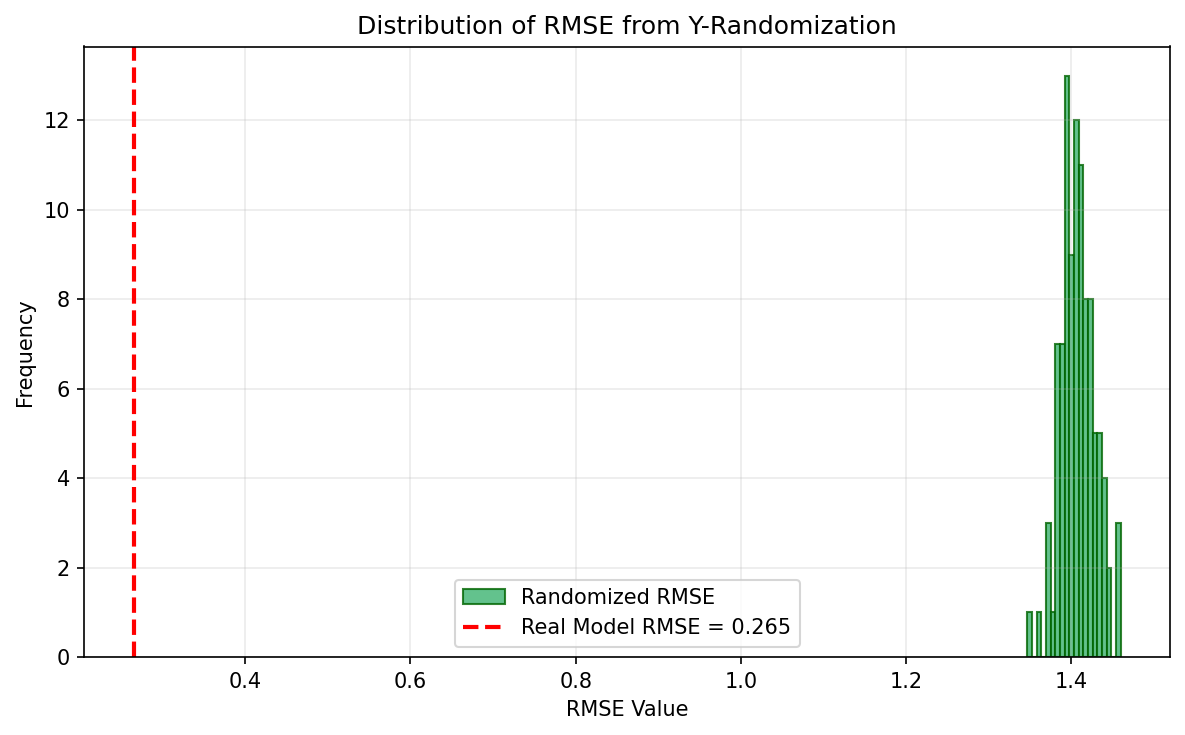

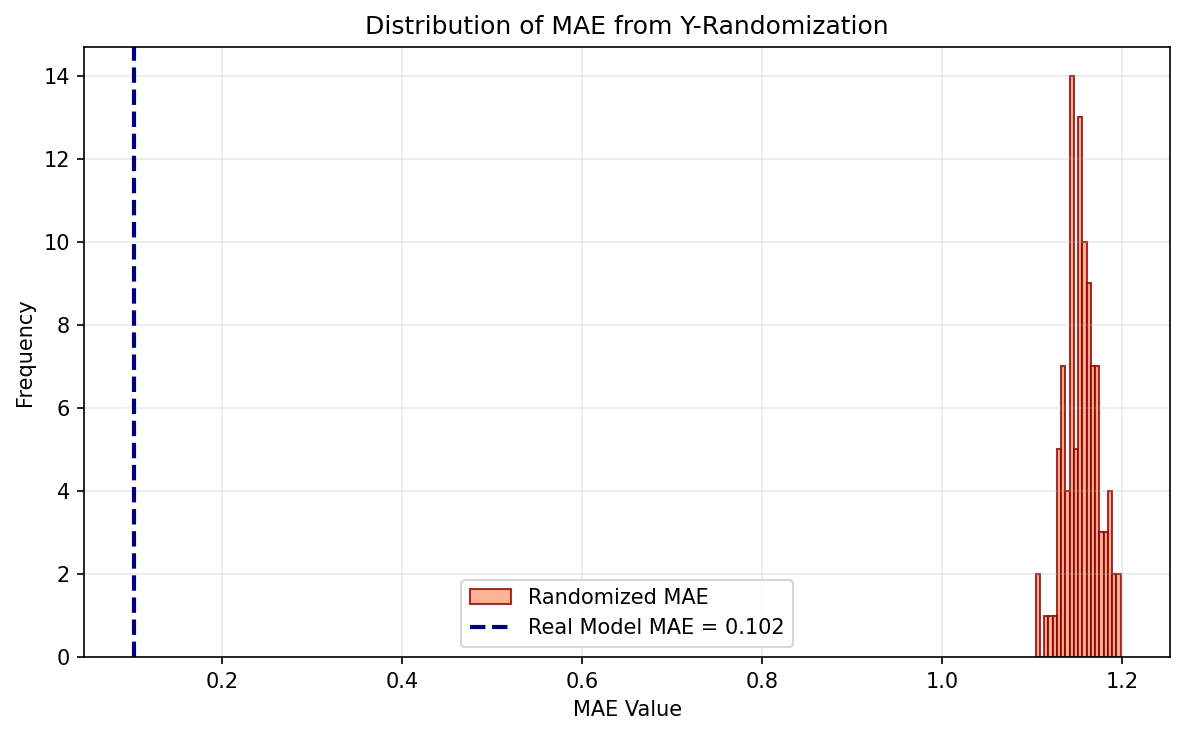

Permutation p-value for RMSE: 0.0000 (frequency real RMSE better than random)
Permutation p-value for MAE: 0.0000 (frequency real MAE better than random)


In [78]:
import matplotlib.pyplot as plt
import numpy as np

real_rmse = 0.265  # Replace with your model's RMSE
real_mae = 0.102   # Replace with your model's MAE

rmse_scores = df_random['RMSE'].values
mae_scores = df_random['MAE'].values

plt.rcParams.update({'figure.dpi': 150})  # High resolution for better quality

# RMSE plot with multiple colors
plt.figure(figsize=(8, 5))
plt.hist(rmse_scores, bins=20, color='mediumseagreen', edgecolor='darkgreen', alpha=0.8, label='Randomized RMSE')
plt.axvline(real_rmse, color='red', linestyle='--', linewidth=2, label=f'Real Model RMSE = {real_rmse:.3f}')
plt.xlabel('RMSE Value')
plt.ylabel('Frequency')
plt.title('Distribution of RMSE from Y-Randomization')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig('Y_randomization_RMSE_highres.png')
plt.show()

# MAE plot with multiple colors
plt.figure(figsize=(8, 5))
plt.hist(mae_scores, bins=20, color='lightsalmon', edgecolor='darkred', alpha=0.8, label='Randomized MAE')
plt.axvline(real_mae, color='navy', linestyle='--', linewidth=2, label=f'Real Model MAE = {real_mae:.3f}')
plt.xlabel('MAE Value')
plt.ylabel('Frequency')
plt.title('Distribution of MAE from Y-Randomization')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig('Y_randomization_MAE_highres.png')
plt.show()

# Permutation p-values
p_value_rmse = np.sum(rmse_scores <= real_rmse) / len(rmse_scores)
p_value_mae = np.sum(mae_scores <= real_mae) / len(mae_scores)

print(f"Permutation p-value for RMSE: {p_value_rmse:.4f} (frequency real RMSE better than random)")
print(f"Permutation p-value for MAE: {p_value_mae:.4f} (frequency real MAE better than random)")


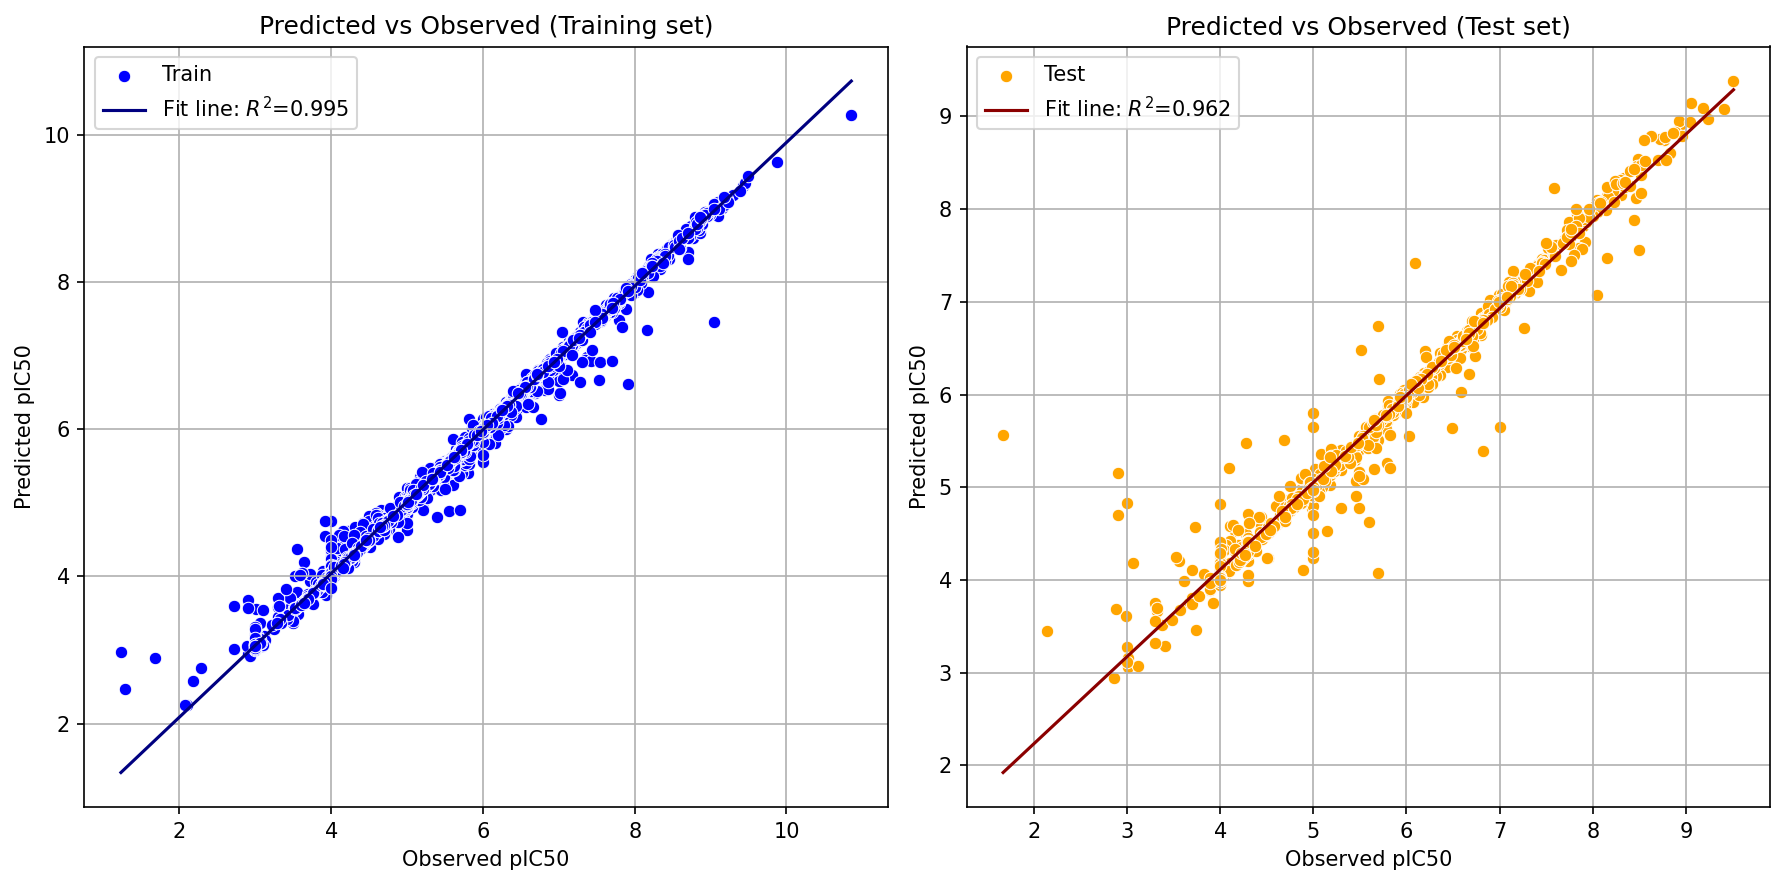

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

def plot_predicted_vs_observed(y_true_train, y_pred_train, y_true_test, y_pred_test):
    plt.figure(figsize=(12, 6))

    # Train set plot
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true_train, y=y_pred_train, color='blue', label='Train')
    # Linear regression
    lr = LinearRegression()
    lr.fit(y_true_train.reshape(-1, 1), y_pred_train)
    line_X = np.array([y_true_train.min(), y_true_train.max()]).reshape(-1, 1)
    line_y = lr.predict(line_X)
    plt.plot(line_X, line_y, color='navy', label=f'Fit line: $R^2$={lr.score(y_true_train.reshape(-1, 1), y_pred_train):.3f}')
    plt.xlabel('Observed pIC50')
    plt.ylabel('Predicted pIC50')
    plt.title('Predicted vs Observed (Training set)')
    plt.legend()
    plt.grid(True)

    # Test set plot
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_true_test, y=y_pred_test, color='orange', label='Test')
    # Linear regression
    lr.fit(y_true_test.reshape(-1, 1), y_pred_test)
    line_X = np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1)
    line_y = lr.predict(line_X)
    plt.plot(line_X, line_y, color='darkred', label=f'Fit line: $R^2$={lr.score(y_true_test.reshape(-1,1), y_pred_test):.3f}')
    plt.xlabel('Observed pIC50')
    plt.ylabel('Predicted pIC50')
    plt.title('Predicted vs Observed (Test set)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('Predicted_vs_Observed_Train_Test.png', dpi=150)
    plt.show()

# Usage: replace these variables with your actual data arrays
# y_train, y_train_pred, y_test, y_test_pred
plot_predicted_vs_observed(y_train.values, y_train_pred, y_test.values, y_test_pred)


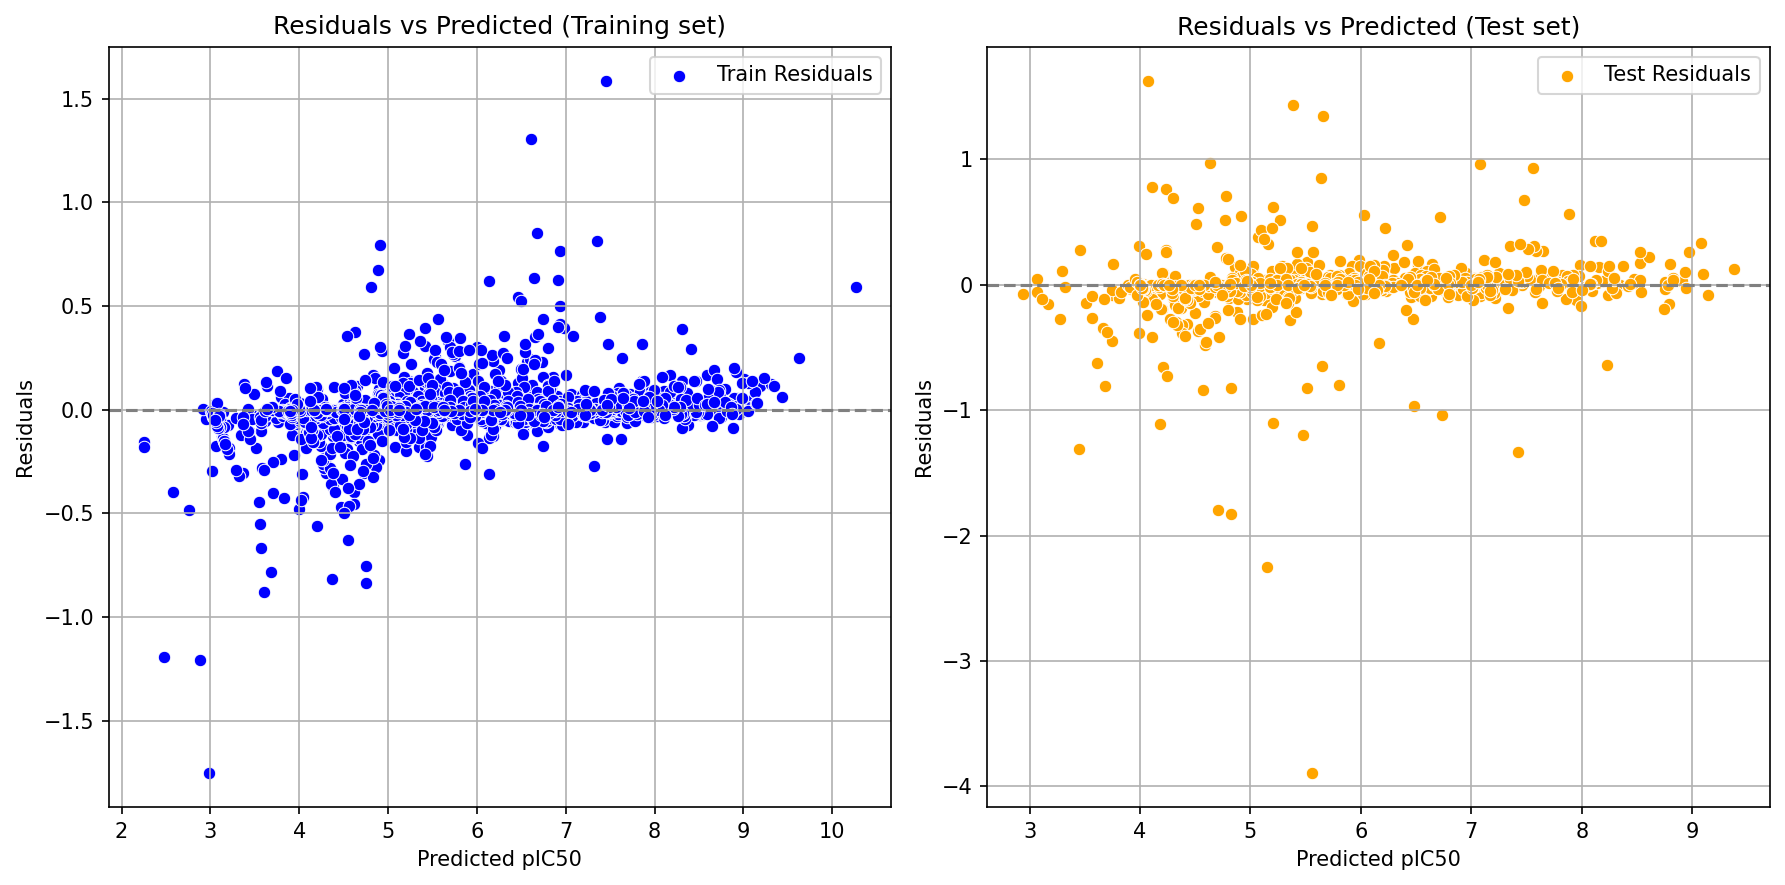

In [80]:
def plot_residuals(y_true_train, y_pred_train, y_true_test, y_pred_test):
    plt.figure(figsize=(12, 6))

    # Train residuals plot
    plt.subplot(1, 2, 1)
    residuals_train = y_true_train - y_pred_train
    sns.scatterplot(x=y_pred_train, y=residuals_train, color='blue', label='Train Residuals')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.xlabel('Predicted pIC50')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Training set)')
    plt.grid(True)

    # Test residuals plot
    plt.subplot(1, 2, 2)
    residuals_test = y_true_test - y_pred_test
    sns.scatterplot(x=y_pred_test, y=residuals_test, color='orange', label='Test Residuals')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.xlabel('Predicted pIC50')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Test set)')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('Residuals_Train_Test.png', dpi=150)
    plt.show()

# Usage: replace these variables with your actual data arrays
plot_residuals(y_train.values, y_train_pred, y_test.values, y_test_pred)


In [81]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming you have:
# X_train_scaled, X_test_scaled as scaled descriptor matrices
# y_test, y_test_pred defined (observed and predicted on test set)

# PCA on training set to reduce dimensionality (keep 95% variance)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)

# Calculate Hat matrix for training set
H_train = X_train_pca @ np.linalg.pinv(X_train_pca.T @ X_train_pca) @ X_train_pca.T
h_train = np.diag(H_train)

# Leverage threshold
p = X_train_pca.shape[1]  # number of PCA components
n = X_train_scaled.shape[0]  # training set size
h_threshold = 3 * (p + 1) / n

# Leverage for test set
X_test_pca = pca.transform(X_test_scaled)
H_test = X_test_pca @ np.linalg.pinv(X_train_pca.T @ X_train_pca) @ X_train_pca.T
h_test = np.diag(H_test)

# Calculate residuals and standardized residuals for test set
residuals_test = y_test - y_test_pred
std_residuals_test = residuals_test / np.std(residuals_test)

# Create Williams plot dataframe
williams_df = pd.DataFrame({'Leverage': h_test, 'Std_Residuals': std_residuals_test})

# Save results if needed
williams_df.to_csv('Williams_plot_data.csv', index=False)


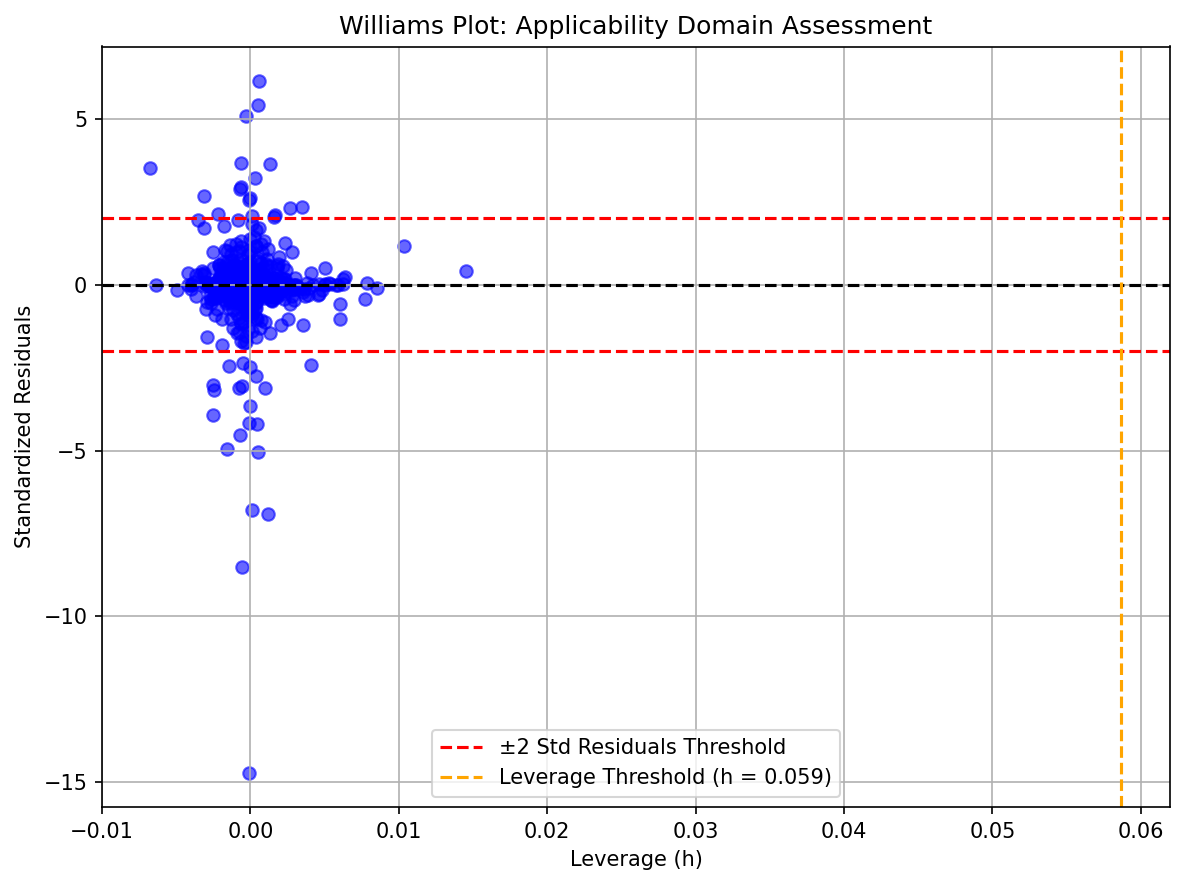

In [82]:
plt.figure(figsize=(8, 6))
plt.scatter(williams_df['Leverage'], williams_df['Std_Residuals'], color='blue', alpha=0.6)
plt.axhline(y=0, color='k', linestyle='--')
plt.axhline(y=2, color='red', linestyle='--', label='±2 Std Residuals Threshold')
plt.axhline(y=-2, color='red', linestyle='--')
plt.axvline(x=h_threshold, color='orange', linestyle='--', label=f'Leverage Threshold (h = {h_threshold:.3f})')
plt.xlabel('Leverage (h)')
plt.ylabel('Standardized Residuals')
plt.title('Williams Plot: Applicability Domain Assessment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Williams_plot.png', dpi=150)
plt.show()


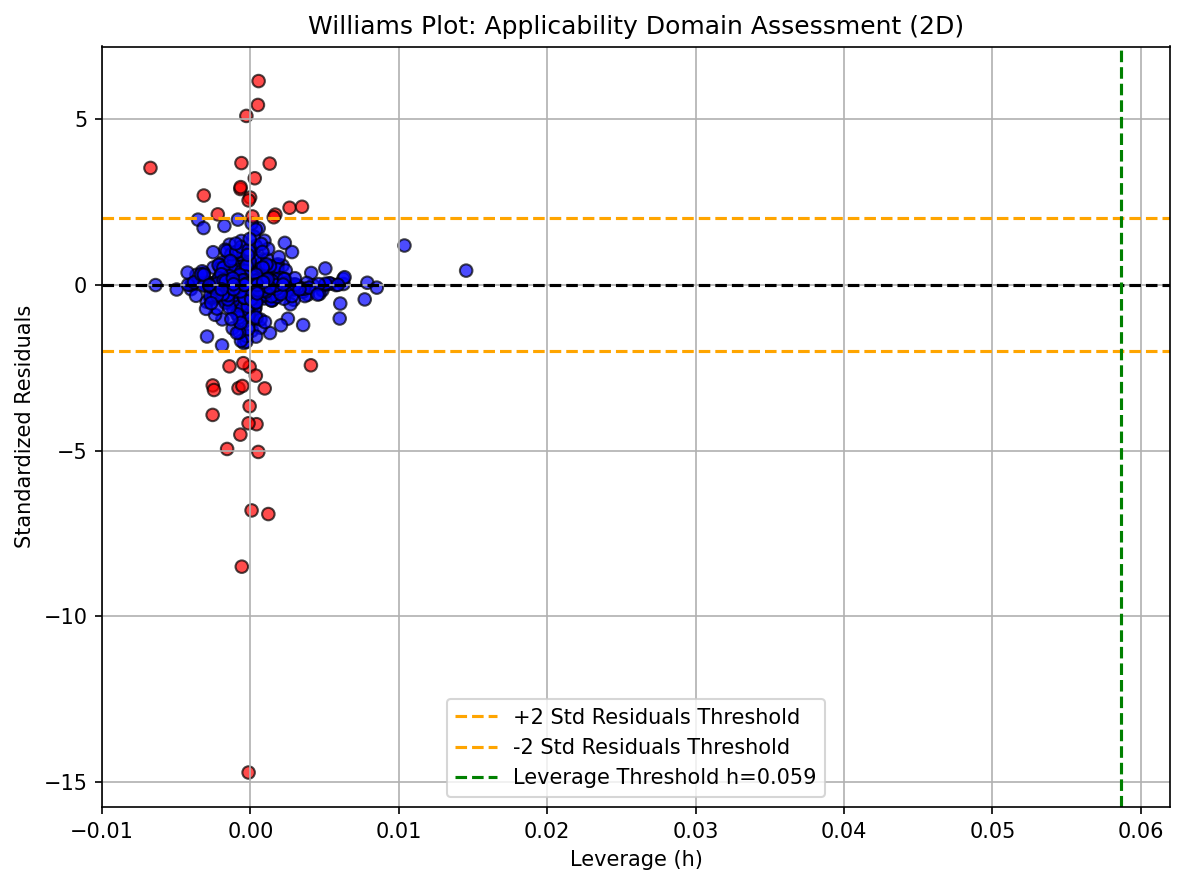

In [84]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Color points based on residual threshold
colors = []
for res in williams_df['Std_Residuals']:
    if res > 2:
        colors.append('red')
    elif res < -2:
        colors.append('red')
    else:
        colors.append('blue')

plt.scatter(williams_df['Leverage'], williams_df['Std_Residuals'], c=colors, alpha=0.7, edgecolor='k')
plt.axhline(y=0, color='k', linestyle='--')
plt.axhline(y=2, color='orange', linestyle='--', label='+2 Std Residuals Threshold')
plt.axhline(y=-2, color='orange', linestyle='--', label='-2 Std Residuals Threshold')
plt.axvline(x=h_threshold, color='green', linestyle='--', label=f'Leverage Threshold h={h_threshold:.3f}')
plt.xlabel('Leverage (h)')
plt.ylabel('Standardized Residuals')
plt.title('Williams Plot: Applicability Domain Assessment (2D)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Williams_plot_2D_colored.png', dpi=150)
plt.show()


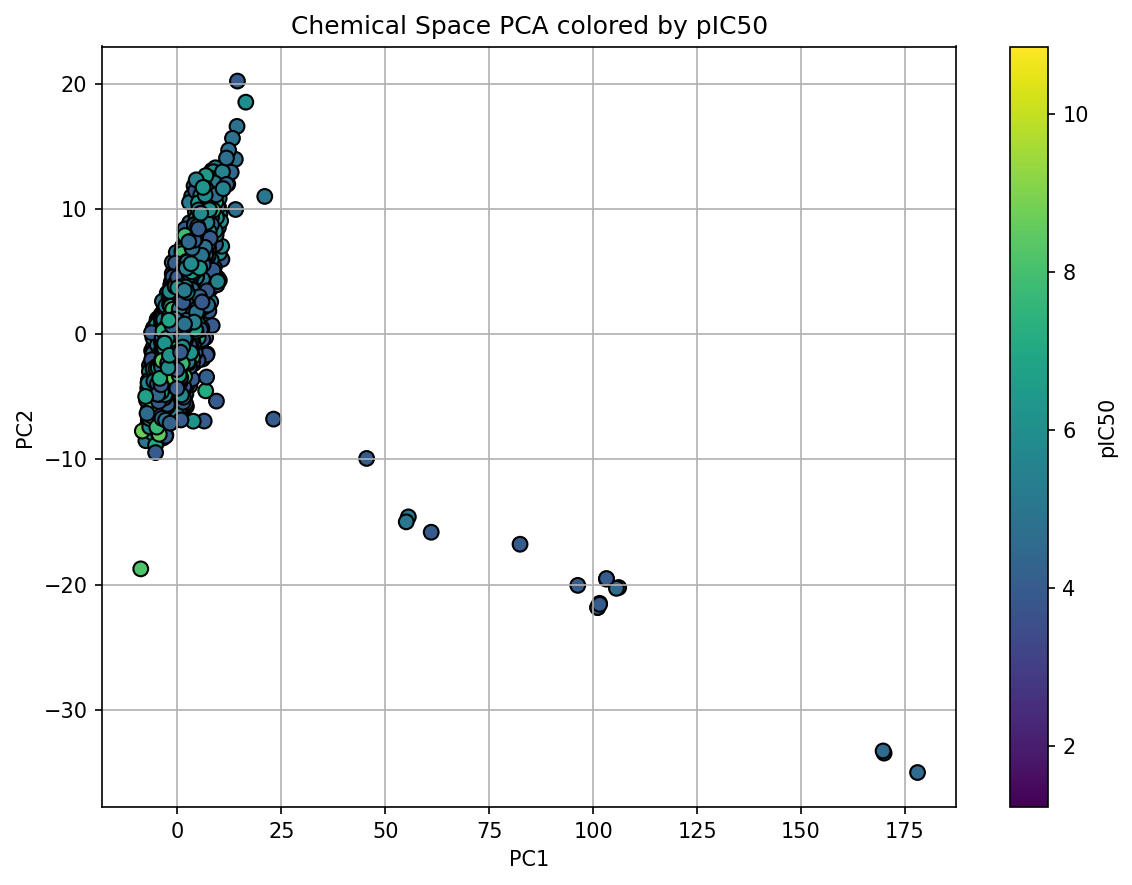

In [83]:
# Combine train and test sets if desired
X_all_scaled = np.vstack([X_train_scaled, X_test_scaled])
y_all = np.concatenate([y_train, y_test])

pca_full = PCA(n_components=2)
pcs = pca_full.fit_transform(X_all_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pcs[:, 0], pcs[:, 1], c=y_all, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(scatter, label='pIC50')
plt.title('Chemical Space PCA colored by pIC50')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()
plt.savefig('PCA_Chemical_Space.png', dpi=150)
plt.show()


In [101]:
import plotly.express as px
from sklearn.decomposition import PCA
import numpy as np

# Combine train and test sets if desired
X_all_scaled = np.vstack([X_train_scaled, X_test_scaled])
y_all = np.concatenate([y_train, y_test])

# Fit PCA with 3 components for 3D plotting
pca_full = PCA(n_components=3)
pcs = pca_full.fit_transform(X_all_scaled)

# Create pandas DataFrame for plotting
import pandas as pd
pca_df = pd.DataFrame({
    'PC1': pcs[:, 0],
    'PC2': pcs[:, 1],
    'PC3': pcs[:, 2],
    'pIC50': y_all
})

# Plotly 3D scatter plot
fig = px.scatter_3d(
    pca_df, x='PC1', y='PC2', z='PC3',
    color='pIC50', color_continuous_scale='Viridis',
    title='Chemical Space PCA colored by pIC50',
    labels={'PC1': 'PC1', 'PC2': 'PC2', 'PC3': 'PC3', 'pIC50': 'pIC50'},
    opacity=0.8
)

fig.update_traces(marker=dict(size=5, line=dict(width=0.5, color='DarkSlateGrey')))
fig.show()

# Save interactive HTML file for sharing
fig.write_html('PCA_Chemical_Space_3D.html')


In [86]:
!pip install plotly

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 226.2 kB/s eta 0:00:41
   -- -------------------

In [99]:
import plotly.graph_objs as go

fig = go.Figure()

# Color points by residual & leverage thresholds in 3D
colors_3d = []
for r, h in zip(williams_df['Std_Residuals'], williams_df['Leverage']):
    if r > 2:                          # Above +2 residual
        colors_3d.append("red")
    elif r < -2:                       # Below -2 residual
        colors_3d.append("orange")
    elif h > h_threshold:              # Outlier in leverage
        colors_3d.append("purple")
    else:                              # Within domain
        colors_3d.append("blue")

fig.add_trace(go.Scatter3d(
    x=williams_df['Leverage'],
    y=williams_df['Std_Residuals'],
    z=williams_df.index,  # or any other index/variable to separate points in 3rd dimension
    mode='markers',
    marker=dict(
        size=5,
        color=colors_3d,
        line=dict(width=0.5, color='DarkSlateGrey'),
        opacity=0.8
    ),
    text=[f'Compound {i}' for i in williams_df.index],
    hoverinfo='text'
))

# Add threshold planes (leverage and residual limits)
fig.add_trace(go.Mesh3d(
    x=[h_threshold, h_threshold, h_threshold, h_threshold],
    y=[-3, 3, 3, -3],
    z=[0, 0, max(williams_df.index), max(williams_df.index)],
    color='green',
    opacity=0.3,
    name='Leverage Threshold'
))

fig.add_trace(go.Mesh3d(
    x=[0, max(williams_df['Leverage']), max(williams_df['Leverage']), 0],
    y=[2, 2, 2, 2],
    z=[0, 0, max(williams_df.index), max(williams_df.index)],
    color='orange',
    opacity=0.3,
    name='Std Residual +2 Threshold'
))

fig.add_trace(go.Mesh3d(
    x=[0, max(williams_df['Leverage']), max(williams_df['Leverage']), 0],
    y=[-2, -2, -2, -2],
    z=[0, 0, max(williams_df.index), max(williams_df.index)],
    color='orange',
    opacity=0.3,
    name='Std Residual -2 Threshold'
))

fig.update_layout(
    scene=dict(
        xaxis_title='Leverage (h)',
        yaxis_title='Standardized Residuals',
        zaxis_title='Compound Index',
        xaxis=dict(range=[0, max(williams_df['Leverage']) * 1.1]),
        yaxis=dict(range=[min(williams_df['Std_Residuals']) * 1.1, max(williams_df['Std_Residuals']) * 1.1]),
        zaxis=dict(range=[0, max(williams_df.index)]),
    ),
    title='Williams Plot: Applicability Domain (3D Interactive)',
    height=700,
    width=900,
    showlegend=True
)

fig.show()


In [100]:
fig.write_html('Williams_plot_3D.html')


In [92]:
plt.savefig('Williams_plot_2D_colored.png', dpi=150)


<Figure size 960x720 with 0 Axes>

In [93]:
import os
print("Your plot was saved in this directory:")
print(os.getcwd())


Your plot was saved in this directory:
C:\Users\Asus


In [96]:
!pip install kaleido

In [111]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

def get_bemis_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)

# Apply to your dataframe (change 'Smiles' to match your column name)
df['murcko_scaffold'] = df['Smiles'].apply(get_bemis_murcko_scaffold)


In [112]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

def get_bemis_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)

# Apply extraction to your dataframe
df['murcko_scaffold'] = df['Smiles'].apply(get_bemis_murcko_scaffold)


In [115]:
scaffold_counts = df['murcko_scaffold'].value_counts()
unique_scaffolds = scaffold_counts.shape[0]
total_molecules = df.shape[0]
scaffold_diversity_index = unique_scaffolds / total_molecules

print(f'Unique scaffolds: {unique_scaffolds}')
print(f'Total molecules: {total_molecules}')
print(f'Scaffold Diversity Index: {scaffold_diversity_index:.3f}')
print('Top 30 privileged scaffolds:')
print(scaffold_counts.head(30))

scaffold_counts.to_csv('murcko_scaffold_counts.csv')


Unique scaffolds: 1488
Total molecules: 4792
Scaffold Diversity Index: 0.311
Top 30 privileged scaffolds:
murcko_scaffold
c1ccc(COc2ccccc2)cc1                               161
c1ccccc1                                           144
c1ccc(-c2csc(NN=C3CCCCC3)n2)cc1                     83
O=c1ccc2ccccc2o1                                    79
O=C(/C=C/c1ccccc1)c1ccccc1                          77
O=C(Nc1ccccc1)c1coc2ccccc2c1=O                      66
c1ccc(C2=NNC(c3ccccc3)C2)cc1                        58
O=c1oc2ccccc2cc1-c1ccccc1                           55
O=C(Nc1ccccc1)c1cc2ccccc2oc1=O                      52
O=c1ccc2ccc(OCc3ccccc3)cc2o1                        51
c1ccc(C2CC2)cc1                                     47
O=C1/C(=C/c2ccccc2)COc2ccccc21                      41
O=C1/C(=C/c2ccccc2)Cc2ccccc21                       31
O=C1OCCc2ccccc21                                    28
O=c1[nH]c(=O)c2c(nc3n2CCCN3Cc2ccccc2)[nH]1          27
O=C(/C=C/c1ccccc1)Nc1ccccc1                         2

In [1]:
from rdkit import Chem
import pandas as pd

def get_ring_systems(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    ri = mol.GetRingInfo()
    atom_rings = ri.AtomRings()
    ring_systems = []
    visited = set()
    for ring in atom_rings:
        ring_set = set(ring)
        if not visited.intersection(ring_set):
            fused = set(ring)
            for other in atom_rings:
                if fused.intersection(other):
                    fused = fused.union(other)
            visited = visited.union(fused)
            submol = Chem.PathToSubmol(mol, list(fused))
            ring_systems.append(Chem.MolToSmiles(submol))
    return ring_systems

# Example usage
df['ring_systems'] = df['Smiles'].apply(get_ring_systems)


NameError: name 'df' is not defined

In [143]:
# Select top 30 scaffolds
top30_scaffold_counts = scaffold_counts.head(30)

# Save to CSV
top30_scaffold_counts.to_csv('top30_murcko_scaffold_counts.csv', header=True)


In [117]:
top_30_scaffolds = scaffold_counts.head(30).index
df_top30 = df[df['murcko_scaffold'].isin(top_30_scaffolds)]


C:\Users\Asus\AppData\Local\Temp\ipykernel_16152\3421915514.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




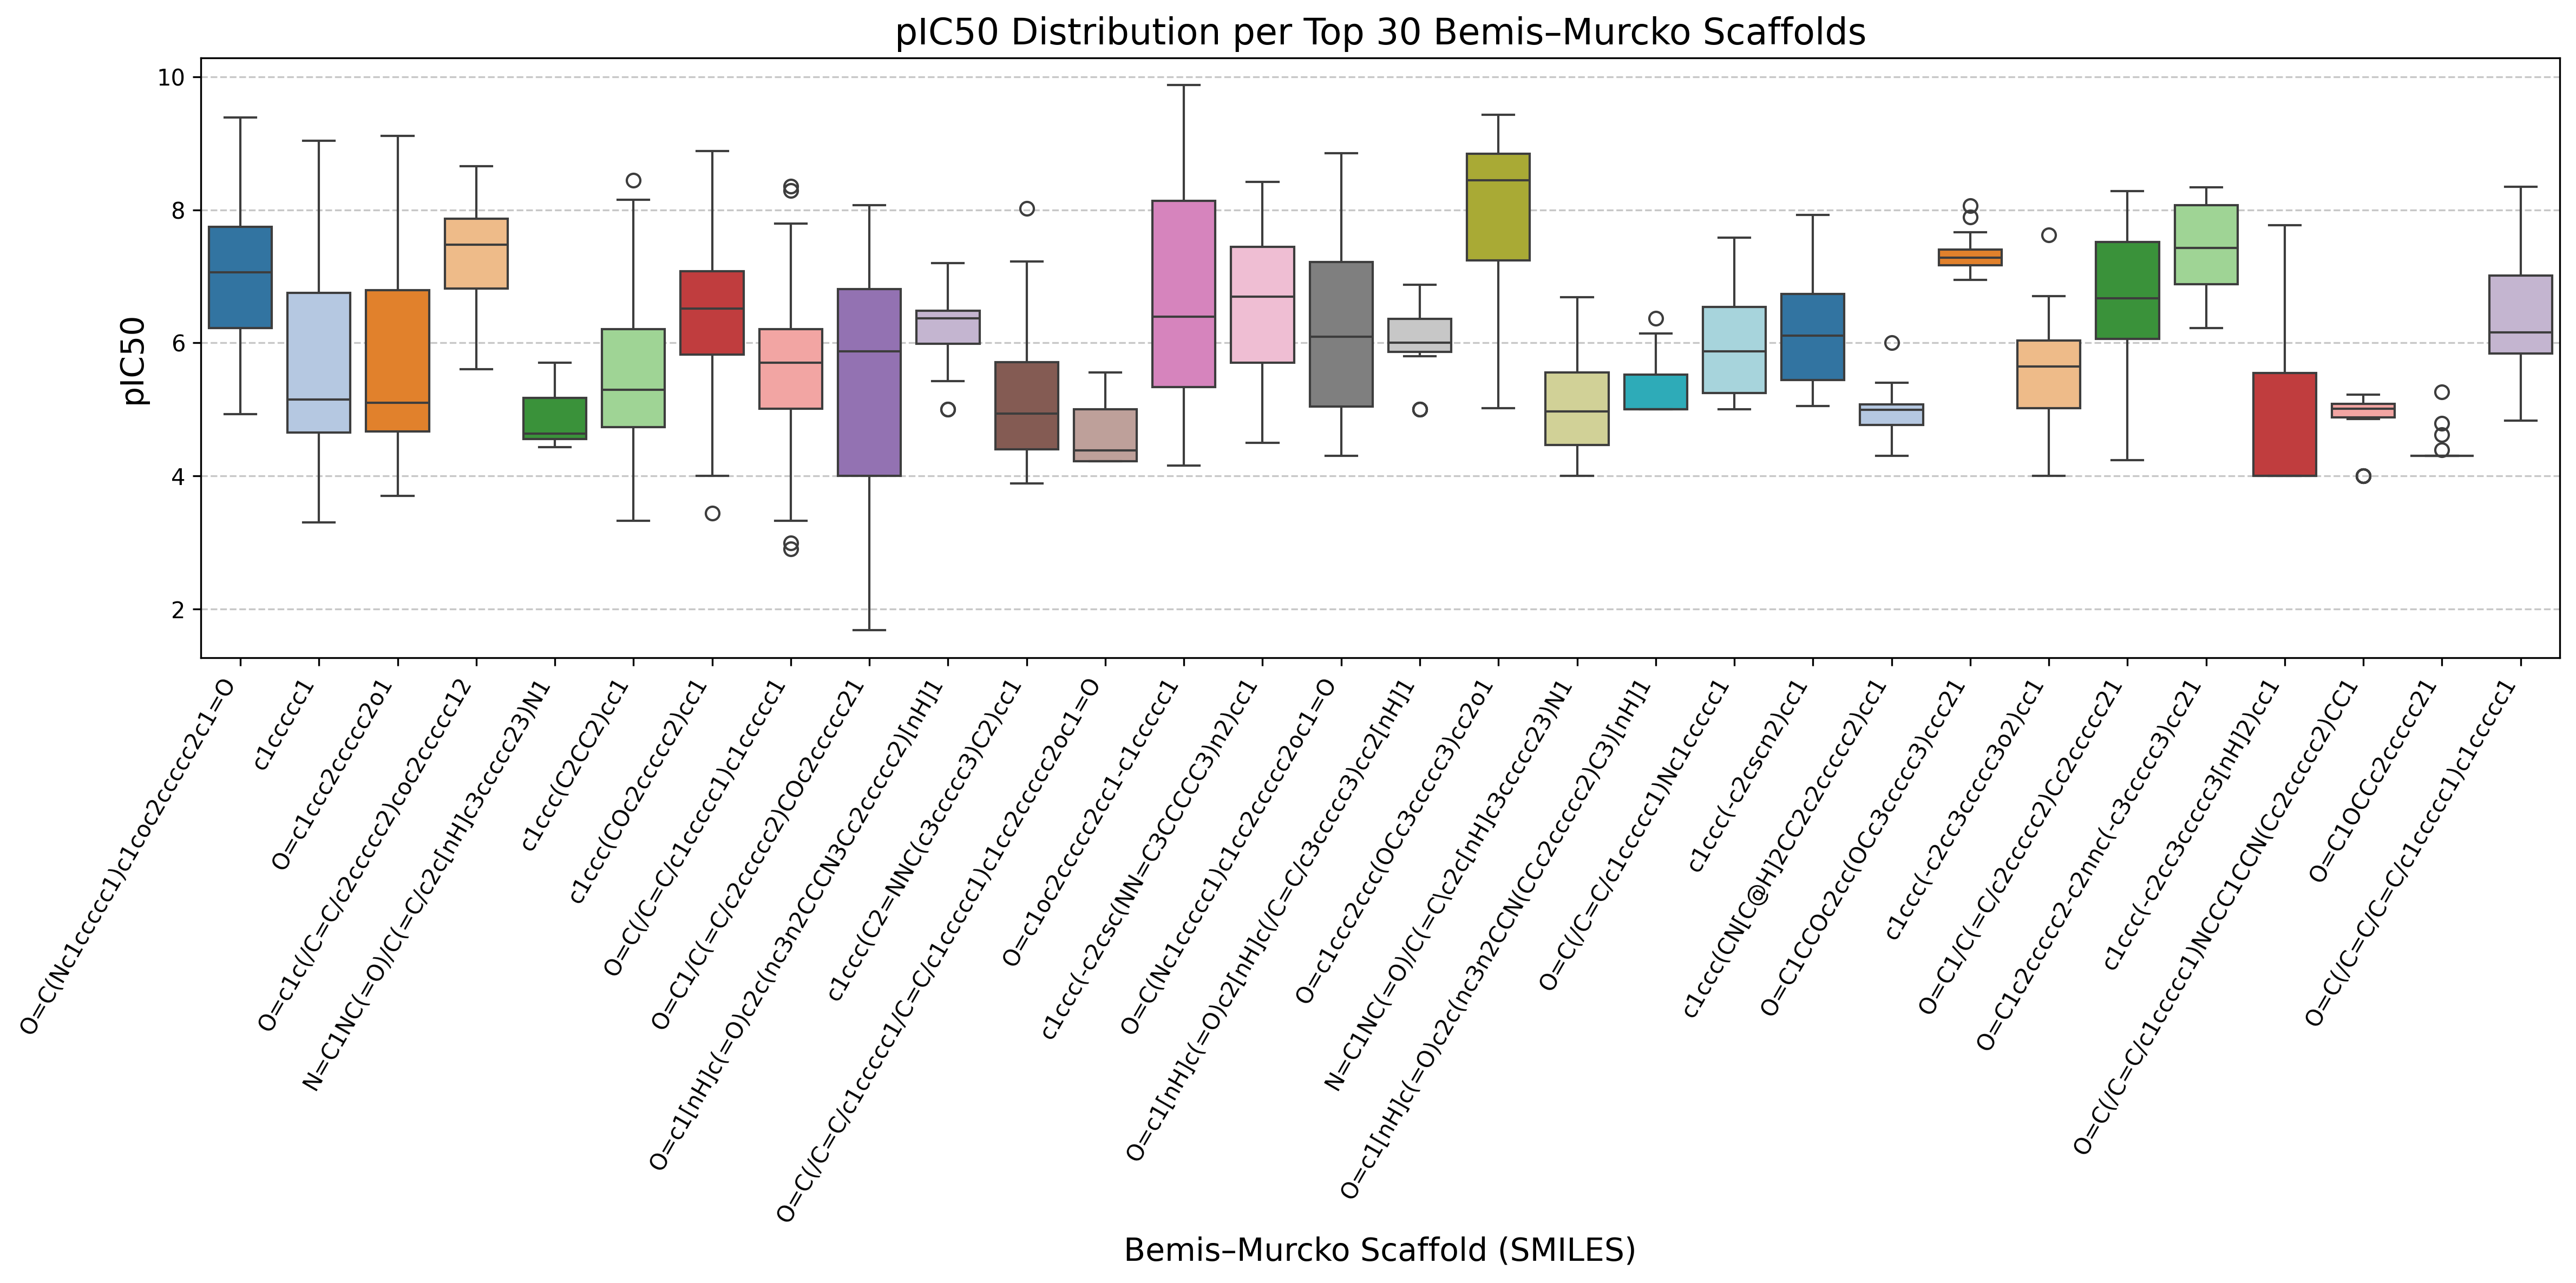

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set figure size and dpi
plt.figure(figsize=(16, 8), dpi=300)  # 300 dpi for publication quality

# Get unique scaffolds in the subset
unique_scaffolds = df_top30['murcko_scaffold'].unique()

# Generate a large color palette with distinct colors for each scaffold
palette_colors = sns.color_palette('tab20', n_colors=len(unique_scaffolds))

# Map each scaffold to a color from the palette
palette = dict(zip(unique_scaffolds, palette_colors))

# Plot boxplot using the custom palette with colors mapped explicitly
sns.boxplot(x='murcko_scaffold', y='pIC50', data=df_top30, palette=palette)

plt.xticks(rotation=60, ha='right', fontsize=10)
plt.title('pIC50 Distribution per Top 30 Bemis–Murcko Scaffolds', fontsize=16)
plt.xlabel('Bemis–Murcko Scaffold (SMILES)', fontsize=14)
plt.ylabel('pIC50', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save high-res plot
plt.savefig('pIC50_distribution_top30_murcko_scaffolds_300dpi_multicolor.png', dpi=300)
plt.show()


In [122]:
from scipy.stats import kruskal
import scikit_posthocs as sp

# Prepare groups for Kruskal-Wallis test (non-parametric ANOVA)
groups = [df_top30[df_top30['murcko_scaffold'] == scaffold]['pIC50'].values for scaffold in top_30_scaffolds]

# Perform Kruskal-Wallis test
stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test statistic: {stat:.3f}')
print(f'Kruskal-Wallis p-value: {p_value:.4g}')

# If p-value indicates significant differences, perform Dunn's post-hoc test
if p_value < 0.05:
    dunn_results = sp.posthoc_dunn(df_top30, val_col='pIC50', group_col='murcko_scaffold', p_adjust='bonferroni')
    dunn_results.to_csv('dunn_posthoc_top30_murcko_scaffolds.csv')
    print("Dunn's post-hoc test completed and results saved to 'dunn_posthoc_top30_murcko_scaffolds.csv'")
else:
    print("No significant differences found among scaffolds with Kruskal-Wallis test")


Kruskal-Wallis test statistic: 484.379
Kruskal-Wallis p-value: 4.633e-84
Dunn's post-hoc test completed and results saved to 'dunn_posthoc_top30_murcko_scaffolds.csv'


Number of significant scaffold pairs: 314


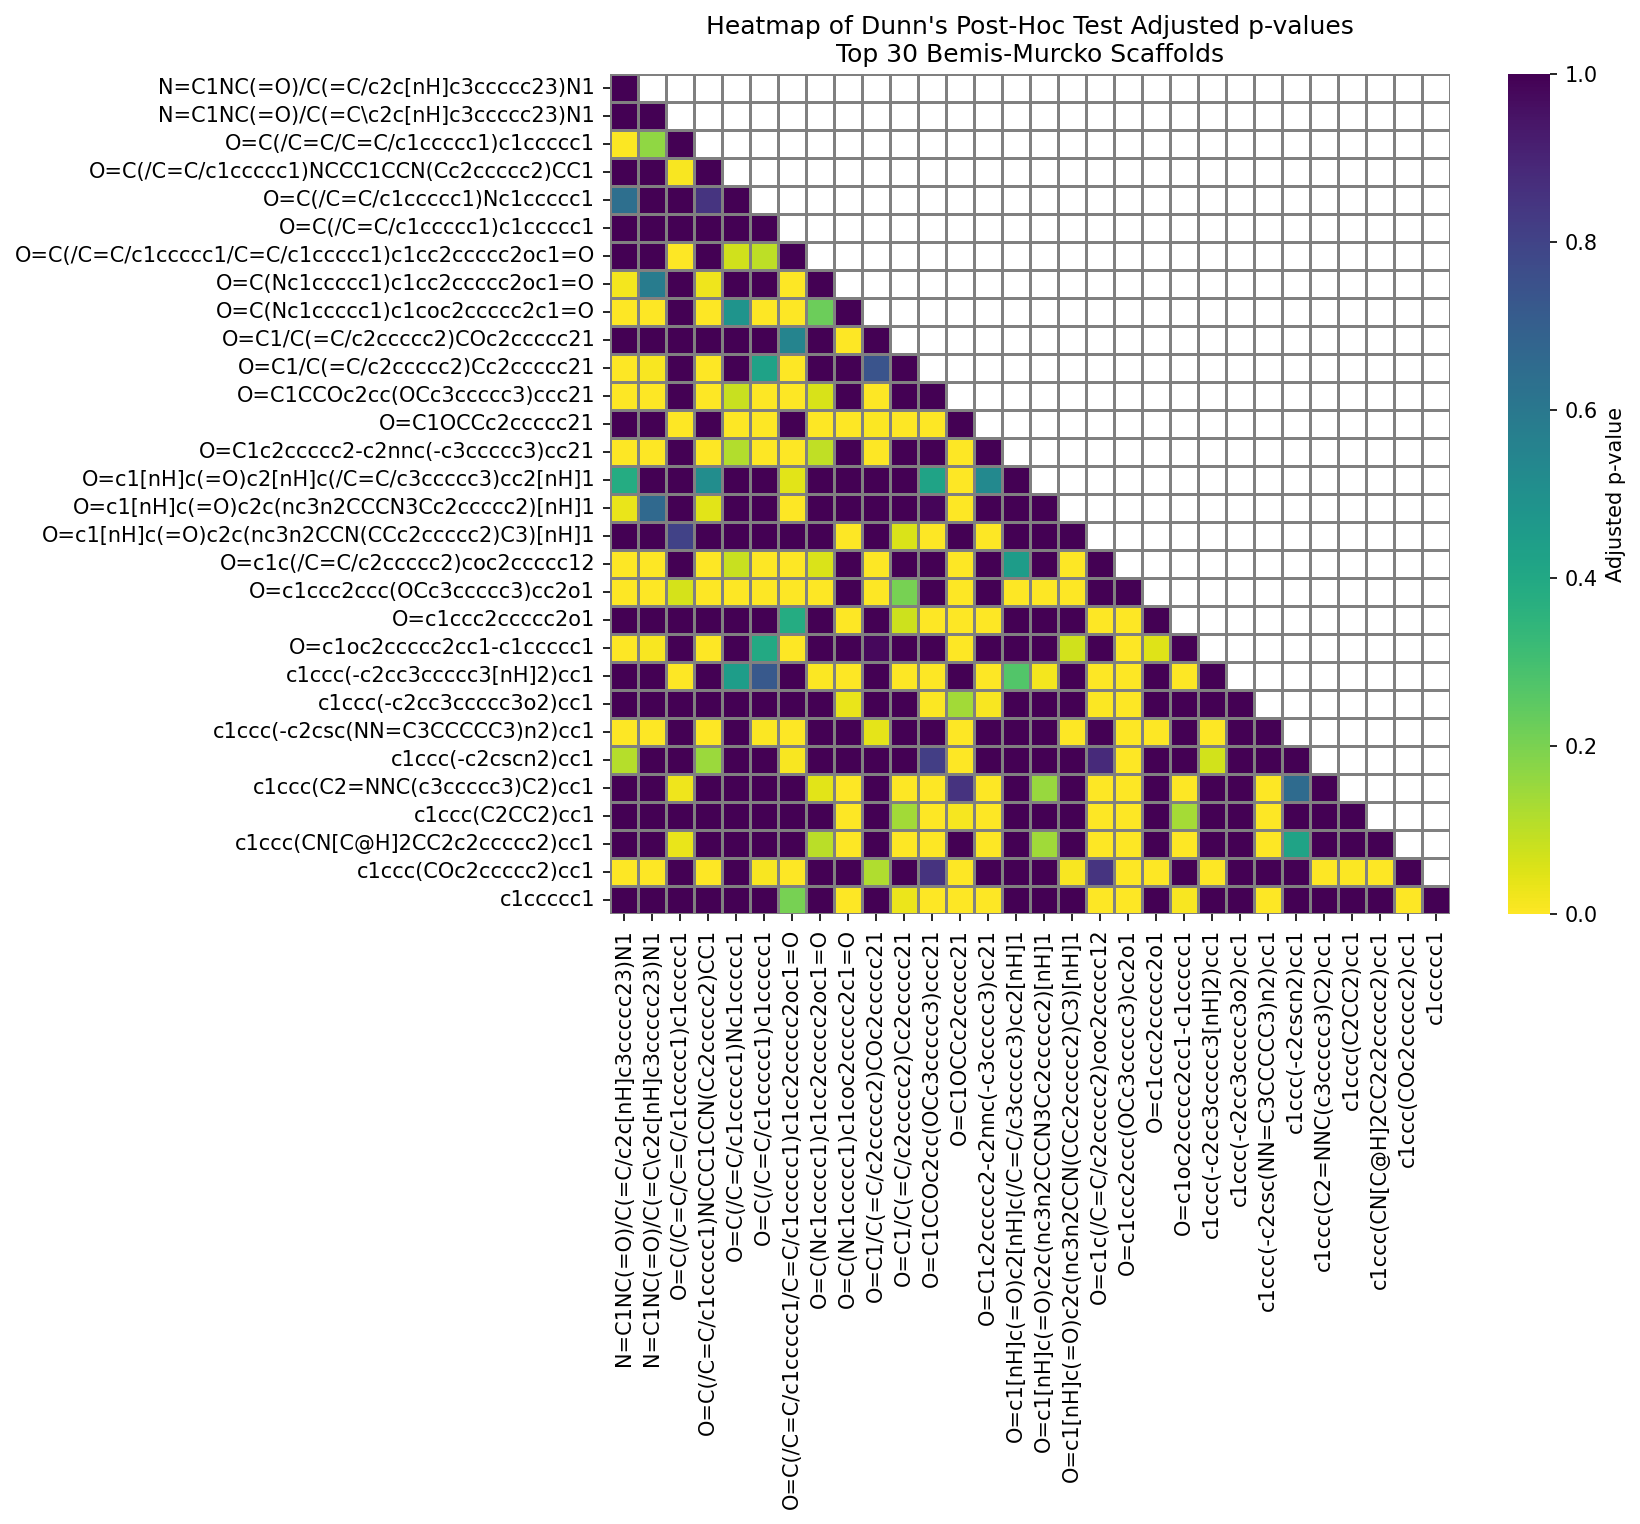

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dunn's post-hoc test results CSV
dunn_results = pd.read_csv('dunn_posthoc_top30_murcko_scaffolds.csv', index_col=0)

# Highlight pairs with significant p-values (<0.05)
significant_mask = dunn_results < 0.05

print(f"Number of significant scaffold pairs: {significant_mask.sum().sum()}")

# Plot heatmap of Dunn's p-values with significant pairs highlighted
plt.figure(figsize=(12, 10))
sns.heatmap(dunn_results, cmap='viridis_r', cbar_kws={'label': 'Adjusted p-value'},
            linewidths=0.5, linecolor='gray', square=True, mask=np.triu(np.ones(dunn_results.shape), k=1))

plt.title('Heatmap of Dunn\'s Post-Hoc Test Adjusted p-values\nTop 30 Bemis-Murcko Scaffolds')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Dunns_test_heatmap_top30_scaffolds.png', dpi=300)
plt.show()


In [125]:
import pandas as pd
import numpy as np

# Load Dunn's test results
dunn_results = pd.read_csv('dunn_posthoc_top30_murcko_scaffolds.csv', index_col=0)

# Convert to long format where each row is a pair
pairs_long = dunn_results.stack().reset_index()
pairs_long.columns = ['Scaffold1', 'Scaffold2', 'Adj_p_value']

# Filter significant pairs
sig_pairs = pairs_long[pairs_long['Adj_p_value'] < 0.05]

# Sort by smallest p-value
sig_pairs_sorted = sig_pairs.sort_values('Adj_p_value')

# Display top 30 most significant pairs
print(sig_pairs_sorted.head(30))


                                           Scaffold1  \
552                     O=c1ccc2ccc(OCc3ccccc3)cc2o1   
378                                 O=C1OCCc2ccccc21   
768                     c1ccc(C2=NNC(c3ccccc3)C2)cc1   
565                     O=c1ccc2ccc(OCc3ccccc3)cc2o1   
569                     O=c1ccc2ccc(OCc3ccccc3)cc2o1   
888                                         c1ccccc1   
368                                 O=C1OCCc2ccccc21   
252                   O=C(Nc1ccccc1)c1coc2ccccc2c1=O   
198  O=C(/C=C/c1ccccc1/C=C/c1ccccc1)c1cc2ccccc2oc1=O   
546                     O=c1ccc2ccc(OCc3ccccc3)cc2o1   
561                     O=c1ccc2ccc(OCc3ccccc3)cc2o1   
648                      c1ccc(-c2cc3ccccc3[nH]2)cc1   
588                                 O=c1ccc2ccccc2o1   
559                     O=c1ccc2ccc(OCc3ccccc3)cc2o1   
377                                 O=C1OCCc2ccccc21   
522                  O=c1c(/C=C/c2ccccc2)coc2ccccc12   
543                     O=c1ccc2ccc(OCc3ccccc3)c

In [128]:
pip install statannotations


Note: you may need to restart the kernel to use updated packages.


In [135]:
import pandas as pd

# Load the QSAR descriptors file (ensure correct path)
descriptors_df = pd.read_csv('QSAR_descriptors_full.csv')


C:\Users\Asus\AppData\Local\Temp\ipykernel_16152\3437906827.py:4: DtypeWarning:

Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.



In [136]:
print(descriptors_df.columns)


Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=268)


In [137]:
merged = df_top30.merge(descriptors_df, on='Smiles')  # Replace with actual common column!


In [147]:
print(scaffold_df.columns)
print(desc_df.columns)


Index(['murcko_scaffold', 'count'], dtype='object')
Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=268)


In [148]:
top30_scaffolds = scaffold_counts.head(30).index
df_top30 = df[df['murcko_scaffold'].isin(top30_scaffolds)]
df_top30.to_csv("dataset_top30_murcko_scaffolds.csv", index=False)


In [150]:
import pandas as pd

# Load top 30 scaffold data and full descriptor data
scaffold_df = pd.read_csv("dataset_top30_murcko_scaffolds.csv")
desc_df = pd.read_csv("QSAR_descriptors_full.csv")

# Make sure 'Smiles' columns match exactly (case and no spaces)
scaffold_df.columns = scaffold_df.columns.str.strip()
desc_df.columns = desc_df.columns.str.strip()

# Merge on 'Smiles'
merged_df = pd.merge(scaffold_df, desc_df, on='Smiles')

# Check the merged data
print(merged_df.head())


  Molecule ChEMBL ID_x Molecule Name_x  Molecule Max Phase_x  \
0        CHEMBL1814070             NaN                   NaN   
1           CHEMBL8706      CLORGILINE                   2.0   
2        CHEMBL2029533             NaN                   NaN   
3        CHEMBL1830793             NaN                   NaN   
4        CHEMBL4852741             NaN                   NaN   

   Molecular Weight_x  #RO5 Violations_x  AlogP_x Compound Key_x  \
0              333.26                0.0     4.06             21   
1              272.18                0.0     3.33     Clorgyline   
2              215.66                0.0     2.53             15   
3              204.18                0.0     1.70              4   
4              264.28                0.0     3.67              5   

                                     Smiles Standard Type_x  \
0  O=C(Nc1ccc(C(F)(F)F)cc1)c1coc2ccccc2c1=O            IC50   
1                C#CCN(C)CCCOc1ccc(Cl)cc1Cl            IC50   
2                

C:\Users\Asus\AppData\Local\Temp\ipykernel_16152\3595068302.py:5: DtypeWarning:

Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.



In [151]:
from scipy.stats import kruskal

key_descriptors = ['MolLogP', 'TPSA', 'NumHDonors'] # Replace with your actual important descriptors

for descriptor in key_descriptors:
    groups = [merged_df[merged_df['murcko_scaffold'] == s][descriptor] for s in merged_df['murcko_scaffold'].unique()]
    stat, pval = kruskal(*groups)
    print(f'{descriptor}: Kruskal-Wallis p-value = {pval:.3e}')


MolLogP: Kruskal-Wallis p-value = 5.127e-172
TPSA: Kruskal-Wallis p-value = 9.523e-75
NumHDonors: Kruskal-Wallis p-value = 4.030e-105


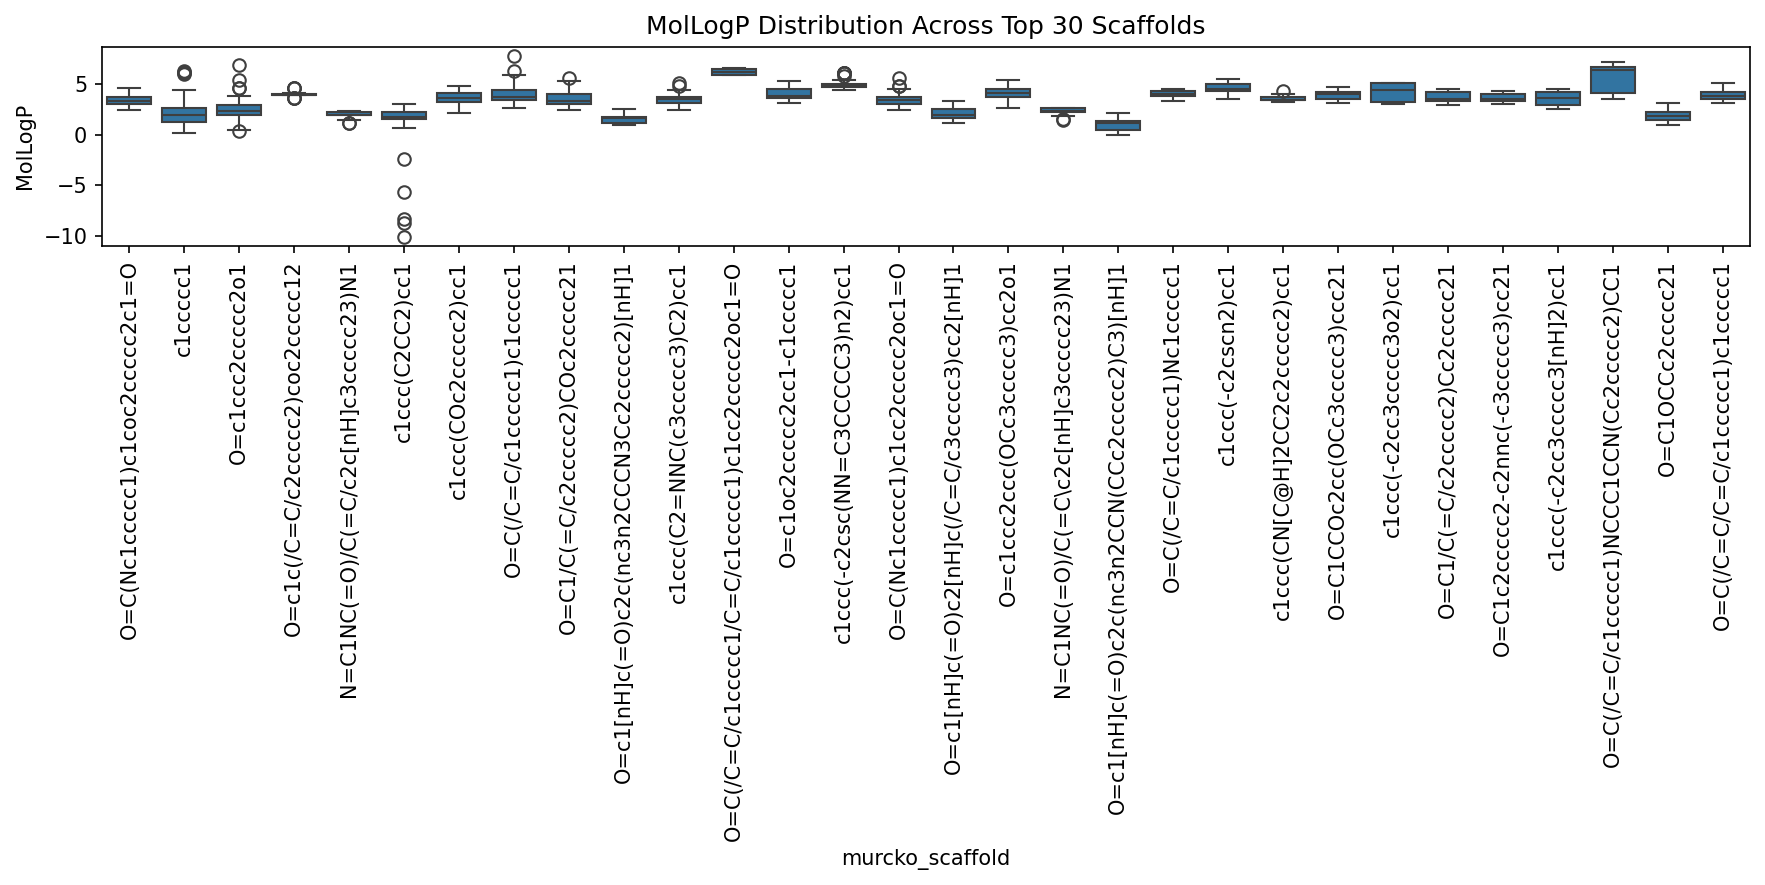

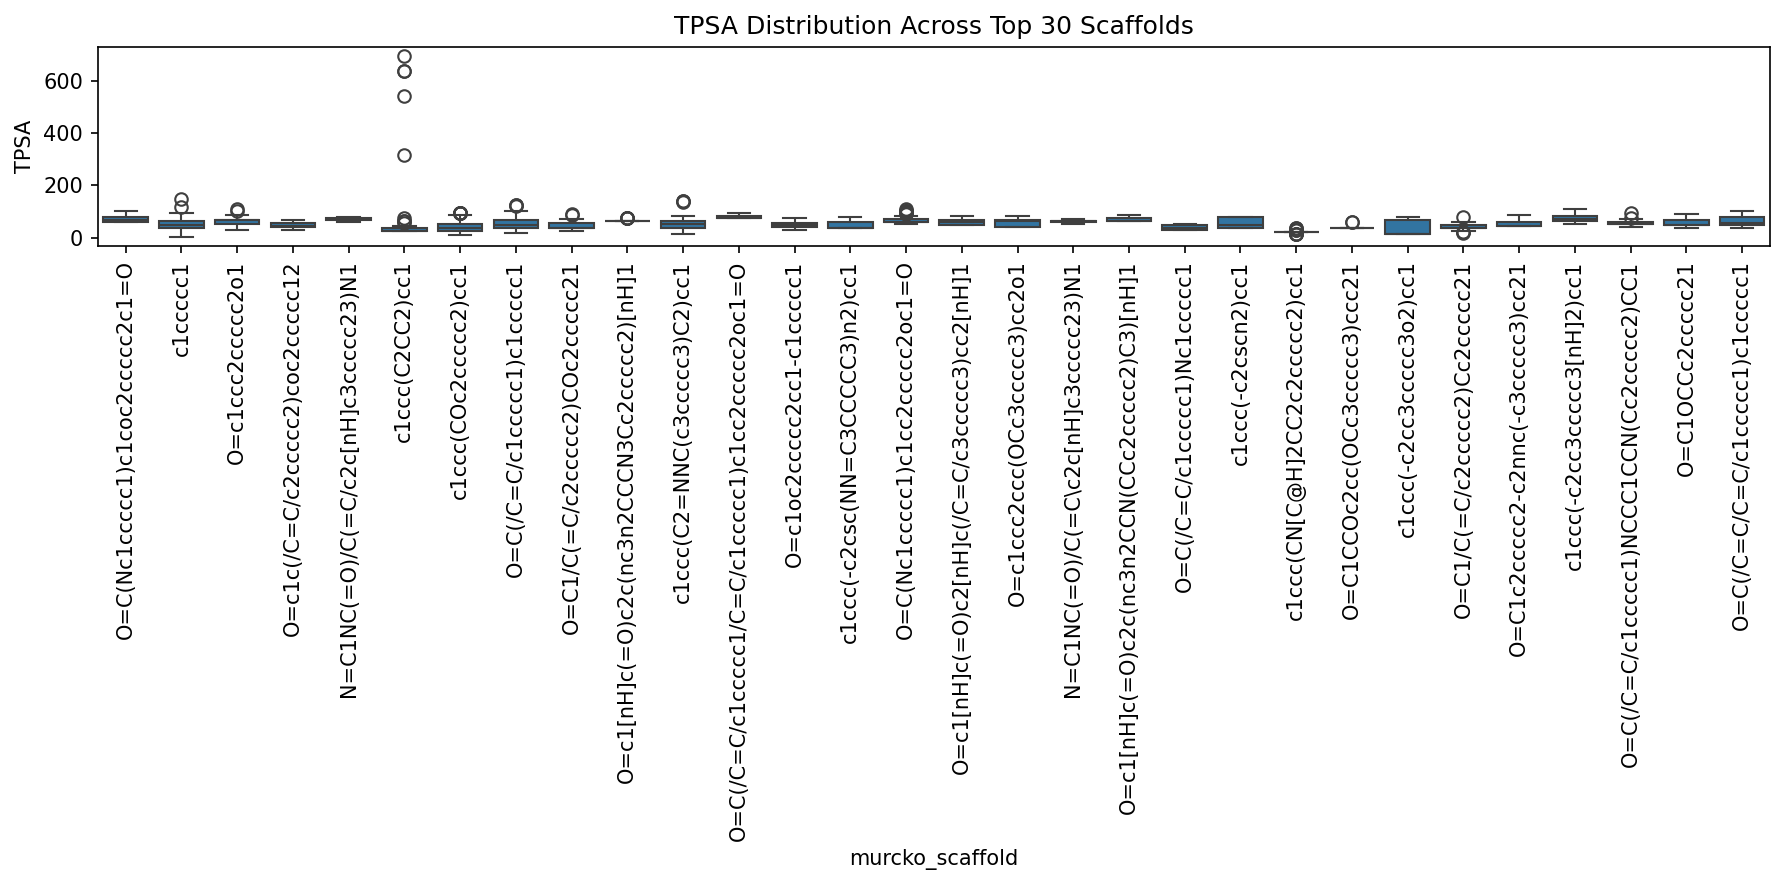

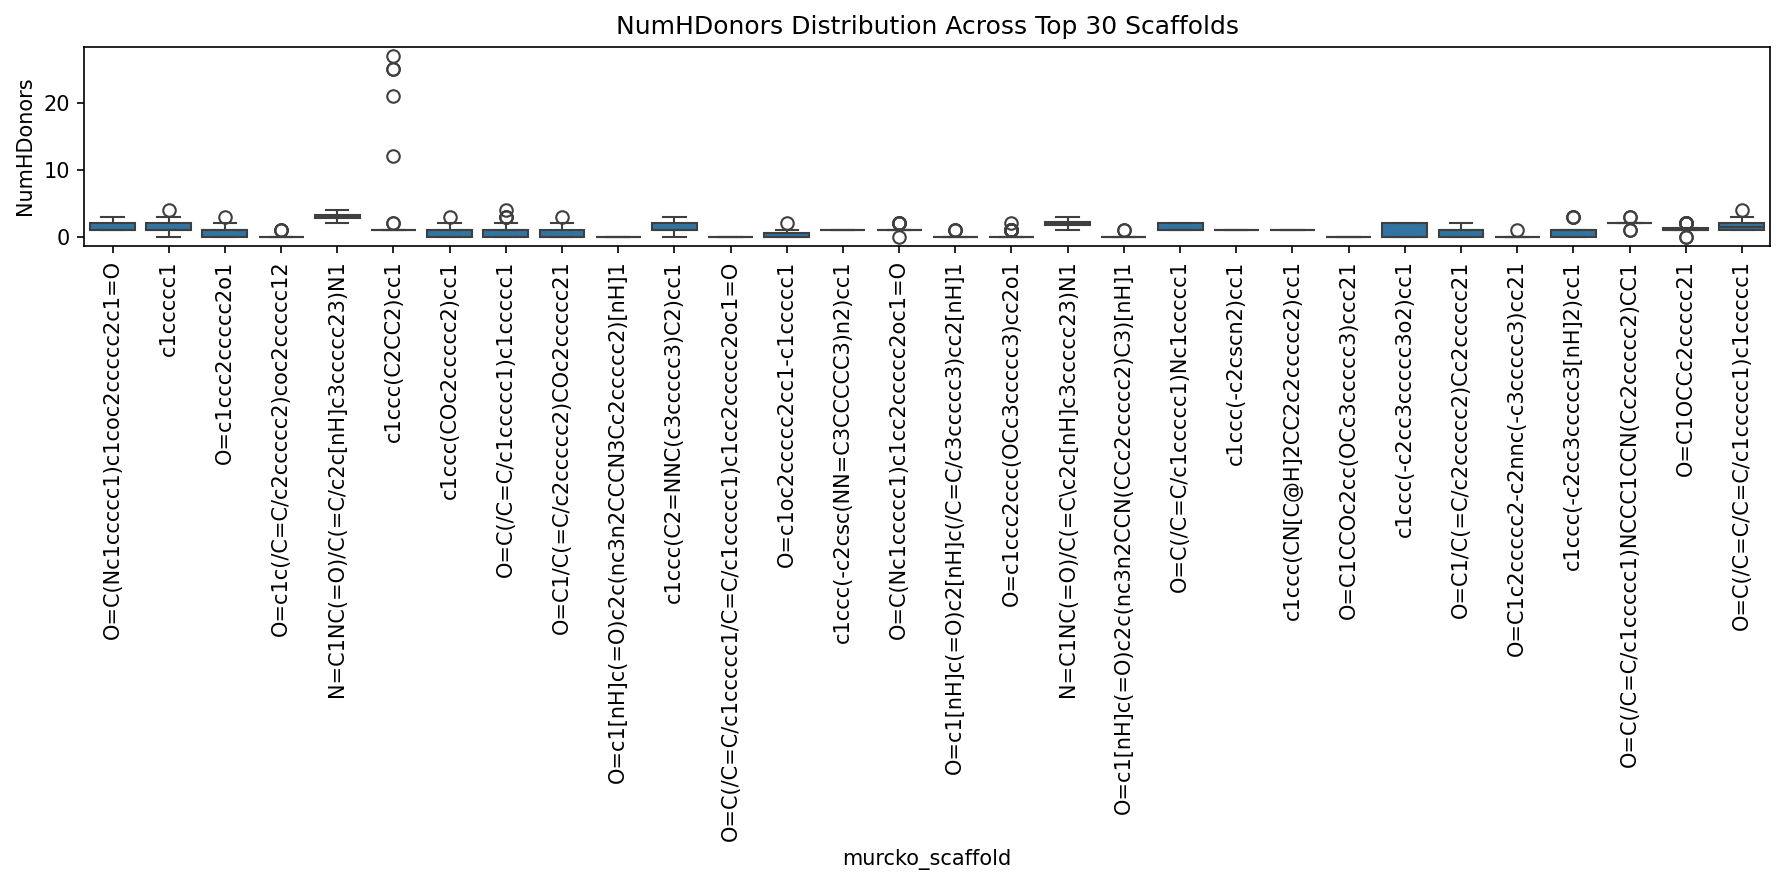

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

for descriptor in key_descriptors:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=merged_df, x='murcko_scaffold', y=descriptor)
    plt.xticks(rotation=90)
    plt.title(f'{descriptor} Distribution Across Top 30 Scaffolds')
    plt.tight_layout()
    plt.show()


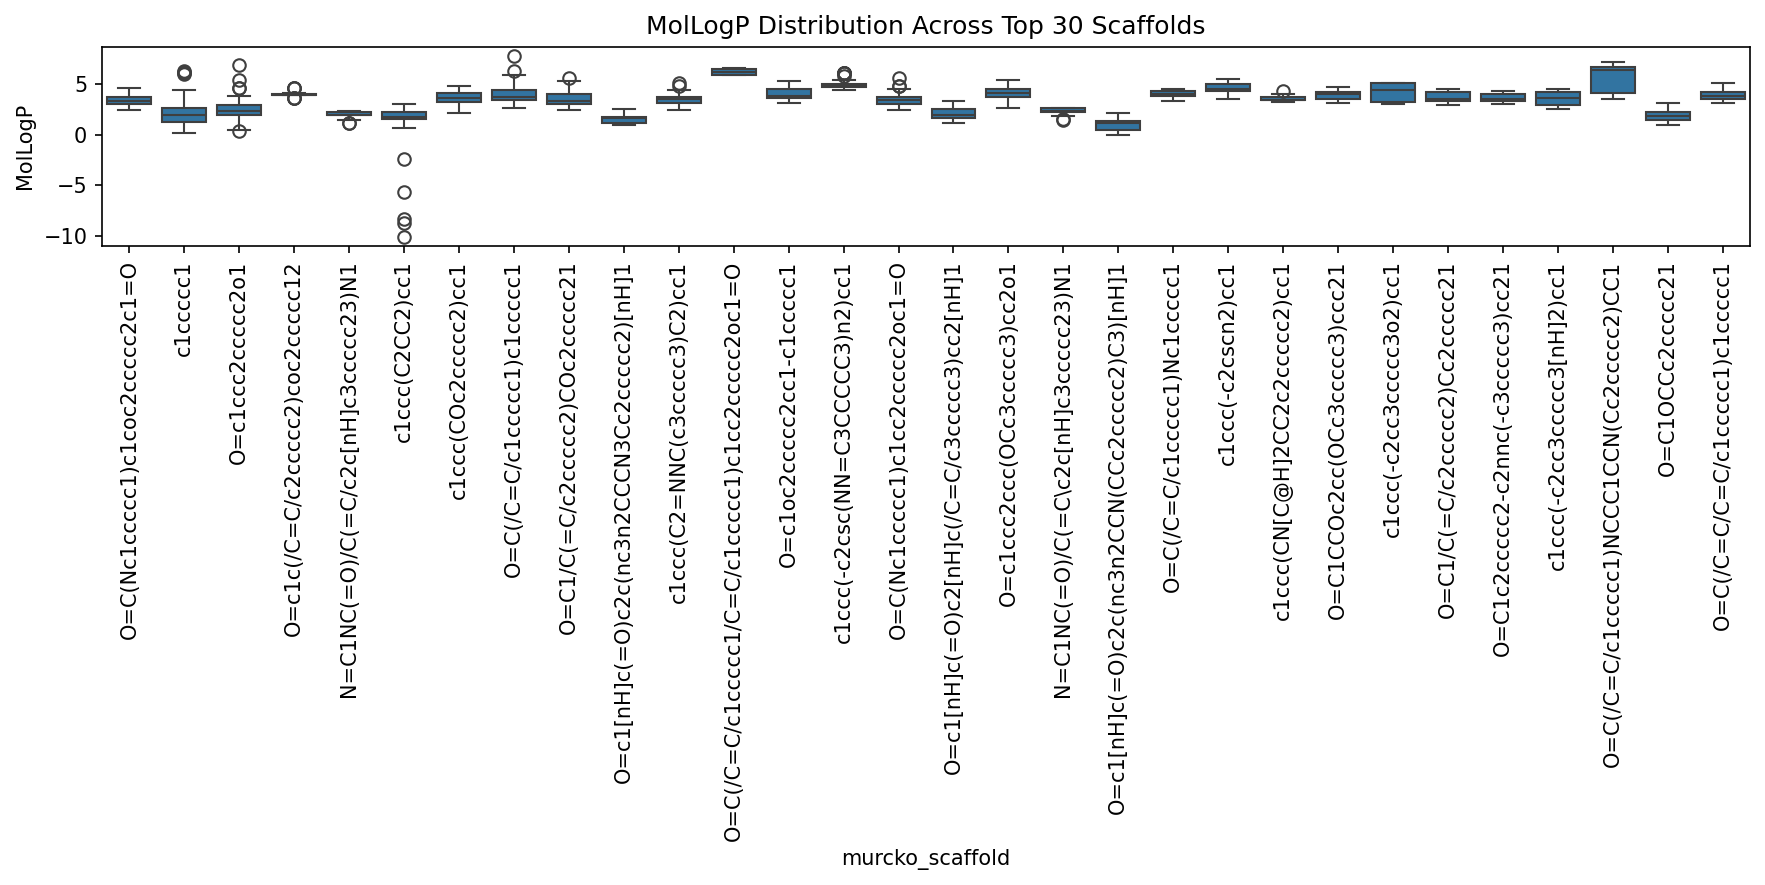

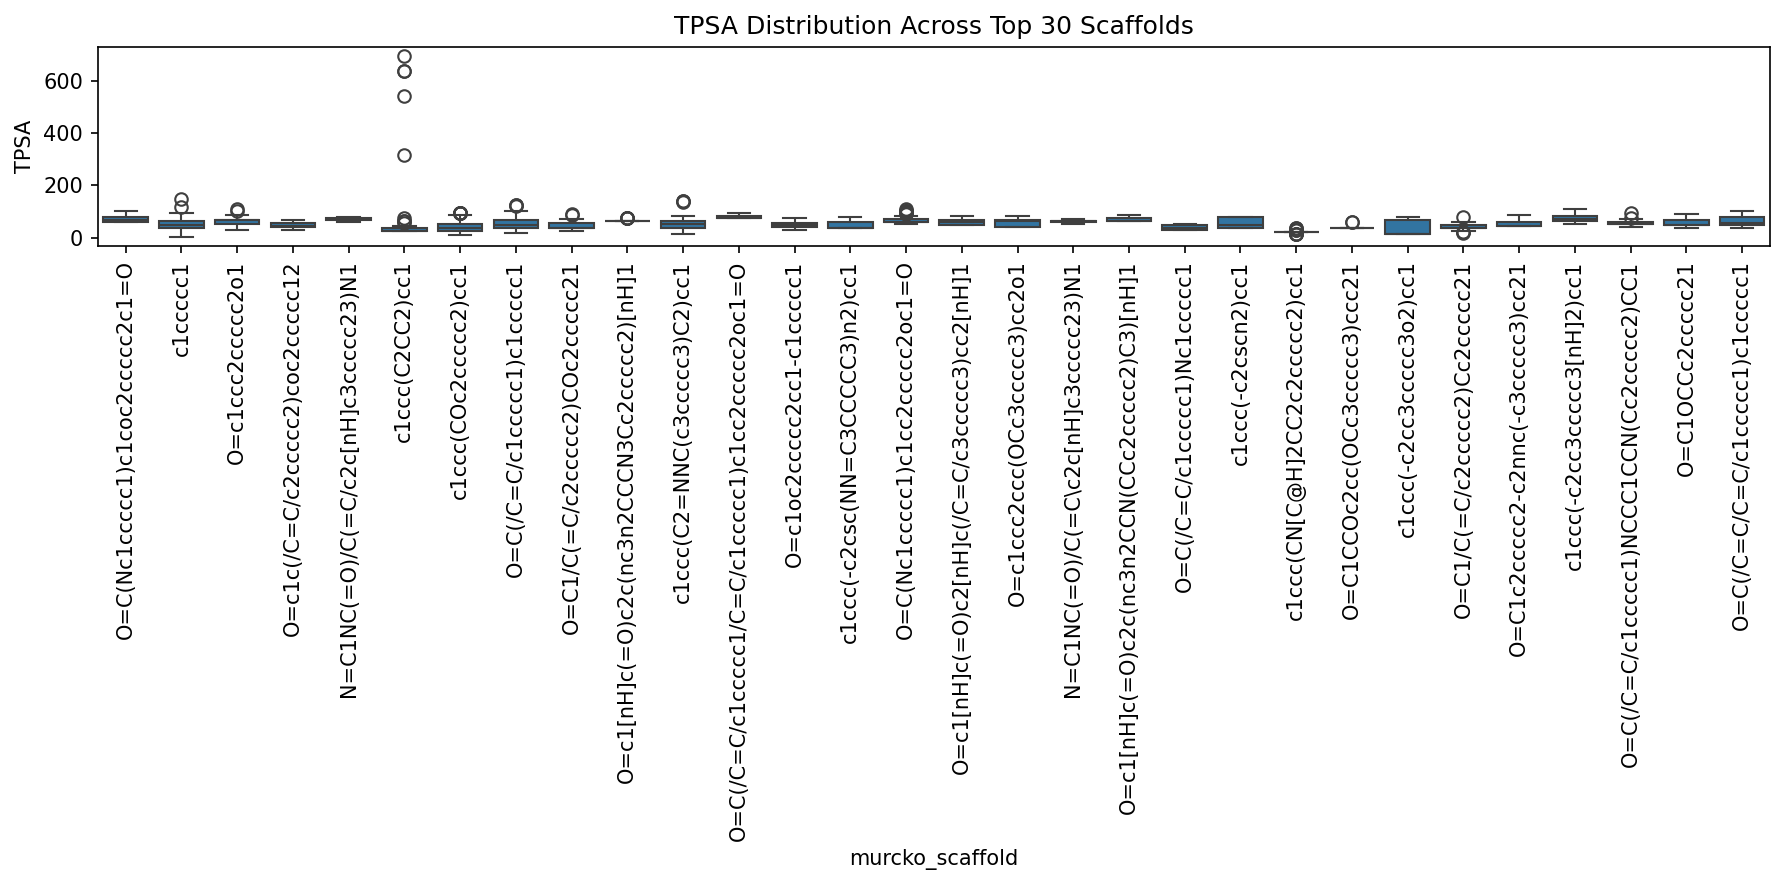

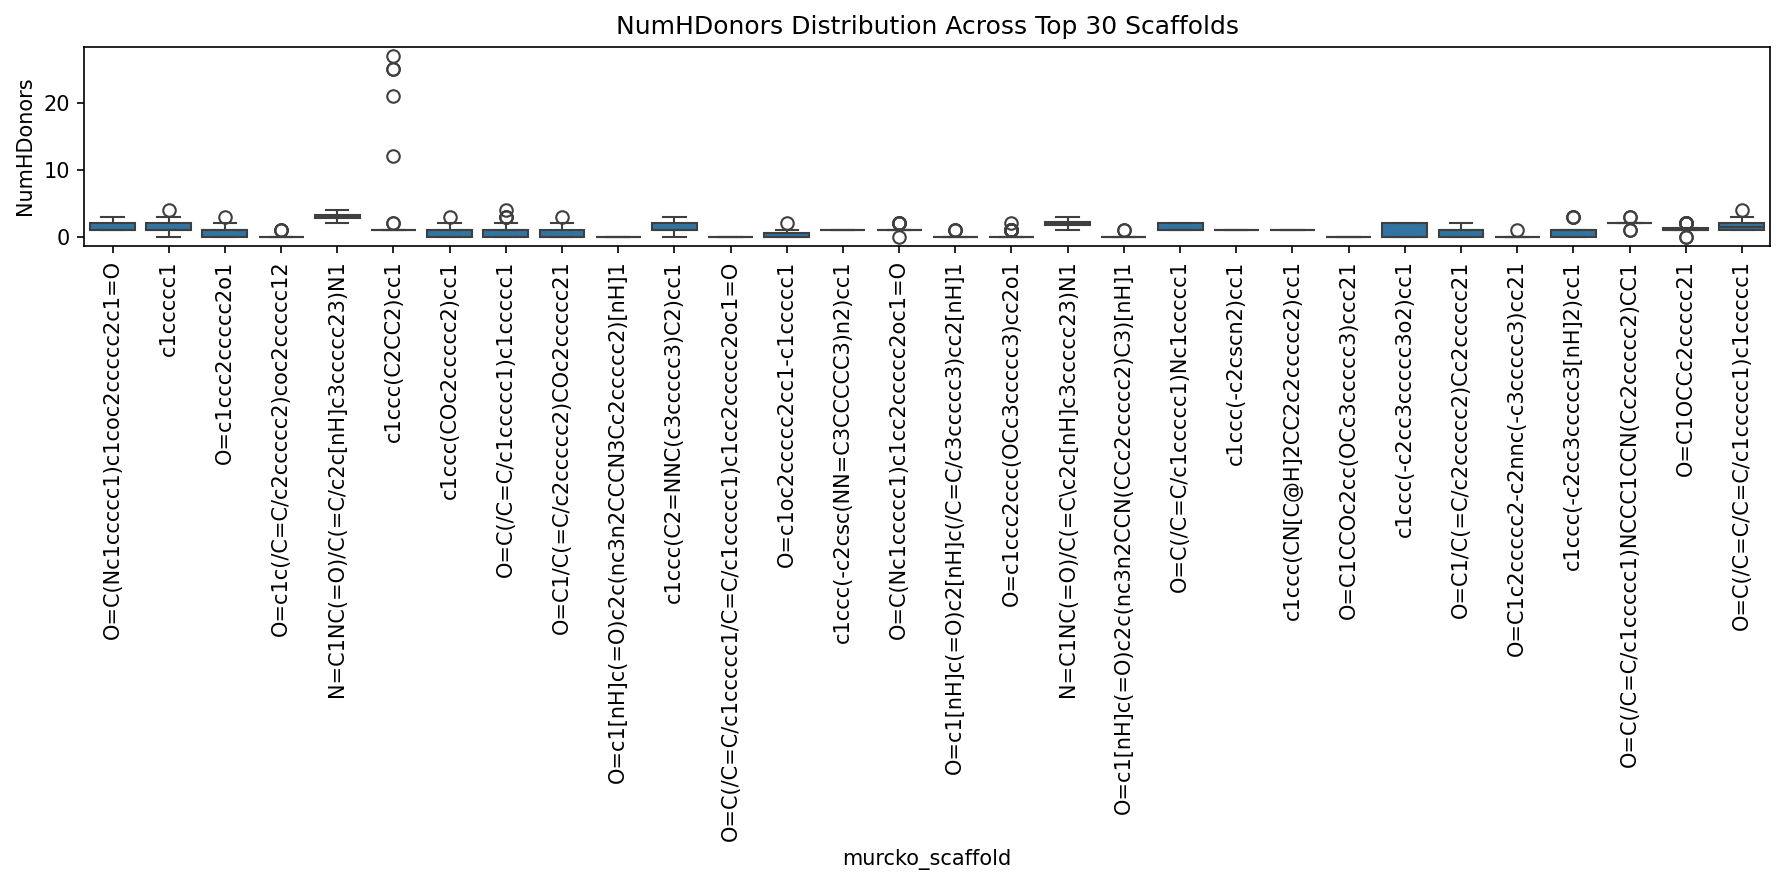

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

for descriptor in key_descriptors:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=merged_df, x='murcko_scaffold', y=descriptor)
    plt.xticks(rotation=90)
    plt.title(f'{descriptor} Distribution Across Top 30 Scaffolds')
    plt.tight_layout()
    plt.show()


In [154]:
from scipy.stats import kruskal

# Pick an example descriptor (replace as needed)
descriptor = 'AlogP_x'
groups = [merged_df[merged_df['murcko_scaffold'] == s][descriptor] for s in merged_df['murcko_scaffold'].unique()]
stat, pval = kruskal(*groups)
print(f'{descriptor}: Kruskal-Wallis p-value = {pval:.3e}')


AlogP_x: Kruskal-Wallis p-value = nan


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.boxplot(data=merged_df, x='murcko_scaffold', y='AlogP_x')
plt.xticks(rotation=80)
plt.title('AlogP_x distribution across top scaffolds')
plt.tight_layout()
plt.show()


NameError: name 'merged_df' is not defined

<Figure size 1400x600 with 0 Axes>

In [159]:
!pip install Pillow